In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# Part 1: Data understanding


## Loading



In [2]:
df = pd.read_csv("dataset/Datafiniti_Pizza_Restaurants_and_the_Pizza_They_Sell_May19.csv")
dfRaw = df


## First inspection


In [3]:
print("Observations and features of dataset: ", df.shape)

df.info()

Observations and features of dataset:  (10000, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10000 non-null  object 
 1   dateAdded           10000 non-null  object 
 2   dateUpdated         10000 non-null  object 
 3   address             10000 non-null  object 
 4   categories          10000 non-null  object 
 5   primaryCategories   10000 non-null  object 
 6   city                10000 non-null  object 
 7   country             10000 non-null  object 
 8   keys                10000 non-null  object 
 9   latitude            10000 non-null  float64
 10  longitude           10000 non-null  float64
 11  menuPageURL         1679 non-null   object 
 12  menus.amountMax     10000 non-null  float64
 13  menus.amountMin     10000 non-null  float64
 14  menus.currency      10000 non-null  object 
 15  men

We notice that the datasets have 24 features and 10000 observations, but almost all of the data are "object" and perhaps some of it can be transpoed to a better Dtype. In order to do that, we have to understand all the variables.

### Id and name

In [4]:
counts = df['id'].value_counts()

dupes = counts[counts > 1]

rowsWithDups = df[df['id'].duplicated(keep=False)].sort_values('id')

print(f"Number of duplicated IDs: {len(dupes)}")


Number of duplicated IDs: 1518


We can see that ID is not unique, but it represents the ID of the business. So an ID should be connected with the name of the business.

We will test in two different cases:
1. Each id has only one name?
2. Each name has only one id?

In [5]:
# First theory: each id has only one name

byID = df.groupby('id')['name'].nunique() # number of unique names per id

print("Distinct ids:", byID.size)
print("Ids with exactly 1 name:", int((byID == 1).sum()), f"({(byID == 1).mean():.2%})")
print("Ids with >1 name (anomalies):", int((byID > 1).sum()))

# printing somes anomalies
if (byID > 1).any():
    sample_ids = byID[byID > 1].index[:5]
    print("\nSample (id ↔ names):")
    print(
        df.loc[df['id'].isin(sample_ids), ['id','name']]
          .drop_duplicates()
          .sort_values(['id','name'])
          .head(20)
          .to_string(index=False)
    )

Distinct ids: 2285
Ids with exactly 1 name: 2285 (100.00%)
Ids with >1 name (anomalies): 0


In [6]:
# Second theory: each name has only one 

# Test B — name → id
byName = df.groupby('name')['id'].nunique() # number of unique ids per name

print("Distinct names:", byName.size)
print("Names with exactly 1 id:", int((byName == 1).sum()), f"({(byName == 1).mean():.2%})")
print("Names with >1 id (chains/homonyms):", int((byName > 1).sum()))

# printing somes anomalies
if (byName > 1).any():
    sample_names = byName[byName > 1].sort_values(ascending=False).index[:5]
    print("\nSample (name <-> ids):")
    print(
        df.loc[df['name'].isin(sample_names), ['name','id','city','province']]
          .drop_duplicates()
          .sort_values(['name','city','province','id'])
          .head(5)
          .to_string(index=False)
    )


Distinct names: 1827
Names with exactly 1 id: 1656 (90.64%)
Names with >1 id (chains/homonyms): 171

Sample (name <-> ids):
                 name                   id           city province
Little Caesar's Pizza AWEKUydU3-Khe5l_edBW         Dayton       OH
Little Caesar's Pizza AWEKTwbZa4HuVbedMB00       Española       NM
Little Caesar's Pizza AVwdCs4skufWRAb51sjs       Hartford       WI
Little Caesar's Pizza AVwdDoS8_7pvs4fz1zoW Hendersonville       NC
Little Caesar's Pizza AVweURCU_7pvs4fzB7G2   Indianapolis       IN


From the code above we can answer the two questions:
1. Yes. Each ID maps to exactly one name (for that business).
2. No. 171 names map to more than one ID, so name is not unique and cannot be used as a key.

### Date columns

The columns in question are dateAdded, dateUpdated and menu.dateSeen. For menu.dateSeen we can just convert it but for dateAdded and dateUpdated there's something more.

The hypothesis is, for this features, that:
- dateAdded is the first observation for the business
- dateUpdated is the last 

In [7]:
da = pd.to_datetime(df['dateAdded'])
du = pd.to_datetime(df['dateUpdated'])

# invarianti base
okAdded  = (da.groupby(df['id']).transform('min') == da).all()
okUpdated = (du.groupby(df['id']).transform('max') == du).all()
okOrder  = (du >= da).all()

print("dateAdded is first per id:", okAdded)
print("dateUpdated is last per id:", okUpdated)
print("dateUpdated >= dateAdded:", okOrder)


dateAdded is first per id: True
dateUpdated is last per id: True
dateUpdated >= dateAdded: True


And the hypothesis is true. We could do some feature engineering and add features like:
- Age of the business
- Last update

For now we will not embrace feature engineering, but we can change te Dtype to perform a better work after.

In [8]:
dateCols = ['dateAdded', 'dateUpdated', 'menus.dateSeen']
for c in dateCols:
    df[c] = pd.to_datetime(
        df[c], 
        errors='coerce', # coercing errors to NaT
        utc=True,  # assuming UTC timezone
        format="mixed" # letting pandas infer format
        ) 

df[dateCols].dtypes

dateAdded         datetime64[ns, UTC]
dateUpdated       datetime64[ns, UTC]
menus.dateSeen    datetime64[ns, UTC]
dtype: object

### String columns

There are some columns that are basic strings. Like ID, Address, Categories, primaryCategories, city, country, keys, menuPageURL, menus.currency, menu.description, menus.name, name, postalCode, priceRangeCurrency and province. The best thing to do is to convert to string and normalize them.


In [9]:
stringCols = [
    'id', 'address', 'categories',
    'primaryCategories', 'city', 'country',
    'keys', 'menuPageURL', 'menus.currency',
    'menus.description', 'menus.name','name',
    'priceRangeCurrency','province'
    ]

df[stringCols] = df[stringCols].astype('string') # convert to string dtype

def _clean(s: pd.Series) -> pd.Series:
    '''
    Clean string data by normalizing unicode characters, stripping whitespace,
    replacing multiple spaces with a single space, and converting common
    missing value indicators to pandas NA.
    '''
    s = s.str.normalize('NFKC').str.strip().str.replace(r'\s+', ' ', regex=True)
    s = s.replace({r'(?i)^(na|n/a|none|null|nan)$': pd.NA, 
                   r'^$': pd.NA}, regex=True)
    return s

for c in stringCols:
    df[c] = _clean(df[c])

df['city'] = df['city'].str.title()
for c in ['country','province','menus.currency','priceRangeCurrency']:
    df[c] = df[c].str.upper()

### Numeric Columns
It is appropriate to assign numeric value to some columns: only postalCode in this case.

In [10]:
df['postalCode'] = pd.to_numeric(
    df['postalCode'],
    errors='coerce', # coercing errors to NaN
    downcast='integer' # downcasting to smallest integer subtype
    )

## Data Dictionary

* **id** - Business ID (unique per business; repeats across rows because each row is a menu item).
* **dateAdded** - First time the business record appears (UTC).
* **dateUpdated** - Last time the business record was seen/updated (UTC, ≥ `dateAdded`).
* **address** - Street address.
* **categories** - Raw categories collected from sources.
* **primaryCategories** - Normalized/primary categories.
* **city** - City.
* **country** - Country code (e.g., US).
* **keys** - Source merge keys for reconciliation (serialized list).
* **latitude** - Latitude.
* **longitude** - Longitude.
* **menuPageURL** - URL of the menu page.
* **menus.amountMax** - Max price for the menu item/size.
* **menus.amountMin** - Listed/min price for the menu item.
* **menus.currency** - Currency for menu prices.
* **menus.dateSeen** - When that item/price was observed (UTC).
* **menus.description** - Menu item description.
* **menus.name** - Menu item name.
* **name** - Business name (not unique; a name can map to multiple IDs).
* **postalCode** - ZIP postal code.
* **priceRangeCurrency** - Currency of the business-level price band.
* **priceRangeMin** - Lower bound of the business price band.
* **priceRangeMax** - Upper bound of the business price band.
* **province** - State/province code (e.g., CA, NY).


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id                  10000 non-null  string             
 1   dateAdded           10000 non-null  datetime64[ns, UTC]
 2   dateUpdated         10000 non-null  datetime64[ns, UTC]
 3   address             10000 non-null  string             
 4   categories          10000 non-null  string             
 5   primaryCategories   10000 non-null  string             
 6   city                10000 non-null  string             
 7   country             10000 non-null  string             
 8   keys                10000 non-null  string             
 9   latitude            10000 non-null  float64            
 10  longitude           10000 non-null  float64            
 11  menuPageURL         1679 non-null   string             
 12  menus.amountMax     10000 non-nul

For easier ffurther analisys the dataframe can be divided in two sub-tables:
1. Business: the table for unique ids
2. Menu items: it's useless to create another tabel just for that, we already have the full dataset.

In [12]:
dfUniqueID = df.drop_duplicates(subset=['id']).reset_index(drop=True)
dfUniqueID.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,menus.currency,menus.dateSeen,menus.description,menus.name,name,postalCode,priceRangeCurrency,priceRangeMin,priceRangeMax,province
0,AVz3Y-7h3D1zeR_xDAqm,2017-06-30 05:05:40+00:00,2019-05-01 15:43:09+00:00,4203 E Kiehl Ave,"Pizza,Restaurant,American restaurants,Pizza Pl...",Accommodation & Food Services,Sherwood,US,us/ar/sherwood/4203ekiehlave/-1051391616,34.832300,...,USD,NaT,<NA>,Cheese Pizza,Shotgun Dans Pizza,72120.0,USD,0,25,AR
1,AVweGPFF_7pvs4fzAAzQ,2016-04-02 04:02:49+00:00,2019-05-01 15:27:50+00:00,25 E Camelback Rd,"Pizza,Pizza Place,Restaurants",Accommodation & Food Services,Phoenix,US,us/az/phoenix/25ecamelbackrd/-727422936,33.509266,...,USD,NaT,<NA>,Pizza Cookie,Sauce Pizza Wine,85012.0,USD,0,25,AZ
2,AVwdRGa9_7pvs4fz4E3K,2016-03-03 18:39:49+00:00,2019-05-01 12:52:25+00:00,3703 Paxton Ave,"Restaurant,Pizza Place,Restaurants",Accommodation & Food Services,Cincinnati,US,us/oh/cincinnati/3703paxtonave/-619797122,39.144883,...,USD,NaT,a saucelessampcomma double cheese pizza with a...,Pizza Blanca,Mios Pizzeria,45209.0,USD,0,25,OH
3,AVwdX4psIN2L1WUfvJB1,2016-03-29 05:08:59+00:00,2019-05-01 12:52:20+00:00,30495 John R Rd,"Pizza,Carry-out food,Pizza Place,Restaurants",Accommodation & Food Services,Madison Heights,US,us/mi/madisonheights/30495johnrrd/-874863116,42.516669,...,USD,NaT,<NA>,Small Pizza,Hungry Howies Pizza,48071.0,USD,25,40,MI
4,AVwdaeTtkufWRAb55pSH,2016-03-31 02:34:04+00:00,2019-05-01 12:50:45+00:00,3600 Eastern Ave,"Pizza,American restaurants,Pizza Place,Pizza e...",Accommodation & Food Services,Baltimore,US,us/md/baltimore/3600easternave/-1270965359,39.286630,...,USD,2016-03-31 02:34:04+00:00,<NA>,Pizza Sub,Spartan Pizzeria,21224.0,USD,0,25,MD


## Data Analisys questions

1. What are the most bought pizas accross the USA? 
2. Costal cities have higher prices than internal cities?
3. Is there a statistically significant difference in the average menu price across the main pizza categories?
4. Do the business-level price ranges (priceRangeMin/Max) align with actual menu item prices? How consistent is that alignment by state?

# Part 2: Data Cleaning & Preparation



## Handling missing values
From dataset infos, after we have converted all of them either specific values or NaN (NaT for dates), it's possible to see that features with missing values are:
1. menuPageURL
2. menus.dateSeen
3. menus.description
4. postalCode

In [13]:
missing = df.isna().mean().sort_values(ascending=False)*100

for col, pct in missing[missing > 0].items():
    print(f"{col:25s}: {pct:5.2f}% missing")

menuPageURL              : 83.21% missing
menus.dateSeen           : 79.72% missing
menus.description        : 62.82% missing
postalCode               :  0.27% missing


menuPageURL, menus.dateSeen and menus.description are useless, we can drop it. PostalCode does not have so much missing values, we can keep it and pay attention later.

In [14]:
df.drop(columns=["menuPageURL", "menus.dateSeen", "menus.description"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id                  10000 non-null  string             
 1   dateAdded           10000 non-null  datetime64[ns, UTC]
 2   dateUpdated         10000 non-null  datetime64[ns, UTC]
 3   address             10000 non-null  string             
 4   categories          10000 non-null  string             
 5   primaryCategories   10000 non-null  string             
 6   city                10000 non-null  string             
 7   country             10000 non-null  string             
 8   keys                10000 non-null  string             
 9   latitude            10000 non-null  float64            
 10  longitude           10000 non-null  float64            
 11  menuPageURL         1679 non-null   string             
 12  menus.amountMax     10000 non-nul

## Handling duplicates

In [15]:
# handling duplicates

def checkRowTotDuplicates(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Check for duplicate rows in the DataFrame and return a DataFrame
    containing only the duplicate rows.
    '''
    dupes = df[df.duplicated(keep=False)].sort_values(list(df.columns))
    return dupes

originalShape = df.shape

for row in checkRowTotDuplicates(df).itertuples():
    df.drop(index=row.Index, inplace=True)

print(f"Removed {originalShape[0] - df.shape[0]} duplicate rows.")

Removed 56 duplicate rows.


The dataset has 56 completely duplicates

## Correction of Inconsistencies and formatting
Correction of Dtypes has already been done on part 1. Checking on values is needed only on columns: country, menus.currency, priceRangeCurrency.

In [16]:
print('Country in dataset are only "US": ', (df['country'] == 'US').all())
print('Menu currency is always "USD": ', (df['menus.currency'] == 'USD').all())
print('Price range currency is always "USD": ', (df['priceRangeCurrency'] == 'USD').all())

Country in dataset are only "US":  True
Menu currency is always "USD":  True
Price range currency is always "USD":  True


### menus.name

In [17]:
df['menus.name'].nunique()

4735

Clearly menus.name is a problem: most of the categories are bad formatted. 

To reduce the complexity of menu item names and improve interpretability, the text was first normalized and enriched by extracting explicit semantic attributes such as crust type, product form (e.g. slice, calzone), dietary labels, size, and a coarse measure of toppings.  
These attributes were encoded as binary features and combined with the remaining textual content to build a richer representation of each menu item.  
The enriched text was vectorized using **TF-IDF** (term frequency-inverse document frequency) with n-grams, enabling a fast and scalable representation.  
Clustering was then performed using **BIRCH** (Balanced Iterative Reducing and Clustering using Hierarchies), which efficiently groups similar items without requiring pairwise distance computations.  
Finally, clusters were summarized using feature prevalence and representative examples, yielding compact and interpretable groupings suitable for further analysis and modeling.

In [18]:
import cleaner
df, cluster_summary = cleaner.clean_categorical_column(
    df=df,
    column="menus.name",
    new_column="menus.cleanedNames",
    cluster_id_column="menus.cluster_id",
    birch_threshold=0.6,
    dummy_prefix ="menu_"
)

/home/manu/Documents/Fondamenti-di-Analisi-dei-dati/cleaner.py:516: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: float(np.average(g[k].astype(float), weights=g["freq"])))
/home/manu/Documents/Fondamenti-di-Analisi-dei-dati/cleaner.py:516: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: float(np.average(g[k].astype(float), weights=g["freq"])))
/home/manu/Documents/Fondamenti-di-Analisi

In [19]:
# --- AFTER CLUSTERING: group rare cleaned names into "OTHER" ---
print("Unique cleaned names (before):", df["menus.cleanedNames"].nunique(dropna=True))

MIN_COUNT = 30  # adjust: 10 / 20 / 30 / 50 depending on desired compression

vc = df["menus.cleanedNames"].value_counts(dropna=True)
keep = vc[vc >= MIN_COUNT].index

df["menus.cleanedNames"] = df["menus.cleanedNames"].where(
    df["menus.cleanedNames"].isin(keep),
    "OTHER"
)

print("Unique cleaned names (reduced):", df["menus.cleanedNames"].nunique(dropna=True))
print("Share OTHER:", (df["menus.cleanedNames"] == "OTHER").mean().round(3))

Unique cleaned names (before): 1942
Unique cleaned names (reduced): 48
Share OTHER: 0.589


In [20]:
import pandas as pd
import numpy as np

# ============================================================
# CONFIGURATION
# ============================================================

RAW_COL = "menus.name"
CLEAN_COL = "menus.cleanedNames"
CLUSTER_COL = "menus.cluster_id"
DUMMY_PREFIX = "menu_"

TOP_K = 15              # number of rows shown in tables
LABEL_THRESHOLD = 0.55  # threshold to assign a semantic label to a cluster

print("Preparing BEFORE vs AFTER clustering summary...")
print(f"Dataset size: {len(df):,} rows")

# ============================================================
# BEFORE: raw menu names (high cardinality)
# ============================================================

before = (
    df[RAW_COL]
    .fillna("")
    .value_counts()
    .head(TOP_K)
    .rename_axis("menus.name (raw)")
    .reset_index(name="count")
)

before["share_%"] = (before["count"] / len(df) * 100).round(2)

print(f"Unique raw menu names: {df[RAW_COL].nunique():,}")

# ============================================================
# AFTER: cluster-level profile using extracted features
# ============================================================

# Identify binary dummy features (0/1 only)
dummy_cols = [
    c for c in df.columns
    if c.startswith(DUMMY_PREFIX) and df[c].dropna().isin([0, 1]).all()
]

print(f"Detected {len(dummy_cols)} binary menu features")

# Cluster size
cluster_size = df.groupby(CLUSTER_COL).size().rename("n_rows")

# Cluster feature prevalence (mean = percentage)
cluster_profile = (
    df.groupby(CLUSTER_COL)[dummy_cols]
      .mean()
      .join(cluster_size)
)

cluster_profile["share_%"] = (
    cluster_profile["n_rows"] / len(df) * 100
).round(2)

print(f"Number of clusters: {cluster_profile.shape[0]}")

# ============================================================
# Semantic label for clusters (for interpretability)
# ============================================================

def build_semantic_label(row, threshold=LABEL_THRESHOLD):
    """
    Create a human-readable label for a cluster
    based on dominant features.
    """
    active_feats = [
        col.replace(DUMMY_PREFIX, "")
        for col in dummy_cols
        if row[col] >= threshold
    ]
    return ", ".join(active_feats[:5]) if active_feats else "(mix)"

cluster_profile["semantic_label"] = cluster_profile.apply(
    build_semantic_label, axis=1
)

# ============================================================
# Example raw menu names per cluster (qualitative inspection)
# ============================================================

examples = (
    df[[CLUSTER_COL, RAW_COL]]
    .dropna()
    .groupby(CLUSTER_COL)
    .head(3)
    .groupby(CLUSTER_COL)[RAW_COL]
    .apply(lambda x: " | ".join(x.astype(str)))
    .rename("examples_raw")
)

cluster_profile = cluster_profile.join(examples, how="left")

# ============================================================
# AFTER table (top clusters by size)
# ============================================================

# Select a subset of readable features for the report
report_features = [
    "menu_is_slice",
    "menu_is_calzone",
    "menu_crust_thin",
    "menu_crust_deepdish",
    "menu_diet_glutenfree",
    "menu_diet_vegetarian",
    "menu_size_small",
    "menu_size_large",
    "menu_topping_1",
    "menu_topping_2",
    "menu_topping_3plus"
]
report_features = [c for c in report_features if c in cluster_profile.columns]

after = (
    cluster_profile
    .reset_index()
    .sort_values("n_rows", ascending=False)
    .loc[:, [CLUSTER_COL, "n_rows", "share_%", "semantic_label", "examples_raw"] + report_features]
    .head(TOP_K)
)

# ============================================================
# Display tables
# ============================================================

print("\n=== BEFORE: Raw menu names ===")
display(before)

print("\n=== AFTER: Clustered menu items ===")
display(after)

# ============================================================
# Key metrics for the report
# ============================================================

metrics = pd.DataFrame({
    "metric": [
        "Dataset rows",
        "Unique raw menu names (before)",
        "Unique cleaned names (after)",
        "Number of clusters",
        "Cardinality reduction"
    ],
    "value": [
        len(df),
        df[RAW_COL].nunique(),
        df[CLEAN_COL].nunique(),
        df[CLUSTER_COL].nunique(),
        f"{(1 - df[CLEAN_COL].nunique() / df[RAW_COL].nunique()) * 100:.1f}%"
    ]
})

print("\n=== Summary metrics ===")
display(metrics)

Preparing BEFORE vs AFTER clustering summary...
Dataset size: 9,944 rows
Unique raw menu names: 4,735
Detected 33 binary menu features
Number of clusters: 1942

=== BEFORE: Raw menu names ===


,menus.name (raw),count,share_%
0,Cheese Pizza,299,3.01
1,White Pizza,225,2.26
2,Hawaiian Pizza,143,1.44
3,Pizza,111,1.12
4,Buffalo Chicken Pizza,110,1.11
5,Margherita Pizza,104,1.05
6,Veggie Pizza,95,0.96
7,Bbq Chicken Pizza,82,0.82
8,Pizza Sub,71,0.71
9,Greek Pizza,70,0.7



=== AFTER: Clustered menu items ===


,menus.cluster_id,n_rows,share_%,semantic_label,examples_raw,menu_is_slice,menu_is_calzone,menu_crust_thin,menu_crust_deepdish,menu_diet_glutenfree,menu_diet_vegetarian,menu_size_small,menu_size_large,menu_topping_1,menu_topping_2,menu_topping_3plus
761,766,720,7.24,(mix),Pizza | Pizza | 1 Topping Pizza,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.022222,0.009722,0.033333
492,495,332,3.34,(mix),Cheese Pizza | Cheese Pizza | Cheese Pizza,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.006024,0.003012,0.000000
106,106,272,2.74,(mix),White Pizza | 16ampquot White Pizza | White Se...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
163,163,178,1.79,(mix),Bbq Chicken Pizza | Bbq Chicken Pizza | Bbq Ch...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
345,347,167,1.68,diet_vegetarian,Veggie Pizza | Vegetarian Pizza | Veggie Pizza,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.000000
1559,1601,152,1.53,(mix),Hawaiian Pizza | Hawaiian Pizza | Hawaiian Pizza,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
101,101,147,1.48,(mix),16ampquot Margherita Pizza | Margherita Pizza ...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25,25,141,1.42,is_slice,2 Topping Pizza Slice | 1 Topping Pizza Slice ...,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.035461,0.014184,0.000000
162,162,132,1.33,(mix),Big Dave's Buffalo Chicken Pizza | Buffalo Win...,0.0,0.0,0.0,0.0,0.007576,0.0,0.0,0.0,0.000000,0.000000,0.000000
1902,1952,95,0.96,crust_sicilian,16ampquot Sicilian Pizza | Sicilian Pizza | Si...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.010526,0.000000,0.000000



=== Summary metrics ===


,metric,value
0,Dataset rows,9944
1,Unique raw menu names (before),4735
2,Unique cleaned names (after),48
3,Number of clusters,1942
4,Cardinality reduction,99.0%


It would be useful to show some of the results of this clustering.

In [21]:
df.columns = df.columns.str.strip()

col_old = "menus.name"
col_new = "menus.cleanedNames"

mapping = (
    df[[col_old, col_new]]
    .dropna()
    .drop_duplicates()
)

changed = mapping[mapping[col_old] != mapping[col_new]]

examples = changed.sample(n=5, random_state=42)

examples

,menus.name,menus.cleanedNames
2356,Small Ham and Pineapple Pizza,OTHER
6127,14ampquot Protesto Pizza,OTHER
1351,Thai Chicken Pizza,OTHER
8327,Zorba The Pizza,OTHER
6448,Kids Pizza Or Pasta (for Kids 10 & Under),OTHER


## Handling Outliers
For outliers we need to check only on numeric values.

In [22]:
obsBeforeCleaning = df.shape[0]

numericCols = df.select_dtypes(include=['number']).columns.tolist()
print(df[numericCols].describe())

          latitude    longitude  menus.amountMax  menus.amountMin  \
count  9944.000000  9944.000000      9944.000000      9944.000000   
mean     38.362102   -90.130276        14.042249        13.423013   
std       4.582589    17.348117        17.645954        10.755641   
min      21.421326  -157.802443         0.000000         0.000000   
25%      34.422946  -104.892459         8.500000         8.000000   
50%      40.105793   -82.953467        13.450000        12.990000   
75%      40.905048   -75.226416        17.950000        16.990000   
max      64.850500   -71.946170      1395.000000       243.000000   

         postalCode  priceRangeMin  priceRangeMax  menus.cluster_id  \
count   9917.000000    9944.000000    9944.000000            9944.0   
mean   46169.814258       4.666633      27.770716        885.796661   
std    31874.110539       9.837828       6.023766        589.496685   
min    10001.000000       0.000000       7.000000               0.0   
25%    14221.000000    

### Latitude
Latitude is a value that must be in range -90 degree (south pole) and +90 degree (north pole) wehre 0 is the equator noting that, for a dataset of pizza business and restaraunt, values near bounds may be considered outliers. Considering that all the dataset restaurants are in USA we consider everything under 18.9 and above 71.4 as **outliers**.

In [23]:
print(f"Max latitude is: {df['latitude'].max()}")
print(f"Min latitude is: {df['latitude'].min()}")

badLat = df['latitude'].notna() & ~df['latitude'].between(18.9, 71.4)
print("Outliers (global lat):", len(df[badLat]))

Max latitude is: 64.8505
Min latitude is: 21.421326
Outliers (global lat): 0


### Longitude
Longitude has a range that varies from -180 to 180 where 0 is Greenwich meridian. In USA covers a range of [-179.14, -66.9] and we will considers outliers everything outside that range.

In [24]:
print(f"Max longitude is: {df['longitude'].max()}")
print(f"Min longitude is: {df['longitude'].min()}")

badLon = df['longitude'].notna() & ~df['longitude'].between(-179.14, -66.9)
print("Outliers (global lon):", len(df[badLon]))

Max longitude is: -71.94617
Min longitude is: -157.802443
Outliers (global lon): 0


### priceRangeMax
In order to identify outliers an idea is to plot an histogram and delete the outliers manually.

In [25]:
tableAddedPMax = dfUniqueID[['dateAdded', 'priceRangeMax']].copy()
tableUpdatedPMax = dfUniqueID[['dateUpdated', 'priceRangeMax']].copy()

yearsAdded = tableAddedPMax['dateAdded'].dropna().dt.year.unique()
yearsUpdated = tableUpdatedPMax['dateUpdated'].dropna().dt.year.unique()

years = sorted(set(yearsAdded) | set(yearsUpdated))

for year in years:
    print(f"\nYear {year}:")
    
    sub_added = tableAddedPMax[tableAddedPMax['dateAdded'].dt.year == year]
    sub_updated = tableUpdatedPMax[tableUpdatedPMax['dateUpdated'].dt.year == year]
    
    prices = sorted(set(sub_added['priceRangeMax'].dropna().unique()) |
                    set(sub_updated['priceRangeMax'].dropna().unique()))
    
    for p in prices:
        count_added = (sub_added['priceRangeMax'] == p).sum()
        count_updated = (sub_updated['priceRangeMax'] == p).sum()
        total = int(count_added + count_updated)
        print(f"  price {p}: {total} occurences (dateAdded={int(count_added)}, dateUpdated={int(count_updated)})")


Year 2014:
  price 25: 5 occurences (dateAdded=5, dateUpdated=0)
  price 26: 1 occurences (dateAdded=1, dateUpdated=0)
  price 40: 5 occurences (dateAdded=5, dateUpdated=0)

Year 2015:
  price 7: 1 occurences (dateAdded=1, dateUpdated=0)
  price 10: 1 occurences (dateAdded=1, dateUpdated=0)
  price 19: 1 occurences (dateAdded=1, dateUpdated=0)
  price 20: 3 occurences (dateAdded=3, dateUpdated=0)
  price 24: 1 occurences (dateAdded=1, dateUpdated=0)
  price 25: 366 occurences (dateAdded=366, dateUpdated=0)
  price 30: 2 occurences (dateAdded=2, dateUpdated=0)
  price 40: 97 occurences (dateAdded=97, dateUpdated=0)
  price 55: 4 occurences (dateAdded=4, dateUpdated=0)

Year 2016:
  price 25: 901 occurences (dateAdded=901, dateUpdated=0)
  price 30: 3 occurences (dateAdded=3, dateUpdated=0)
  price 35: 1 occurences (dateAdded=1, dateUpdated=0)
  price 40: 187 occurences (dateAdded=187, dateUpdated=0)
  price 55: 5 occurences (dateAdded=5, dateUpdated=0)

Year 2017:
  price 18: 1 occuren

There no outliers here.

### priceRangeMin
For priceRangeMin it's possible to consider the same method as priceRangeMax.

In [26]:
tableAddedPMin = dfUniqueID[['dateAdded', 'priceRangeMin']].copy()
tableUpdatedPMin = dfUniqueID[['dateUpdated', 'priceRangeMin']].copy()

yearsAddedMin = tableAddedPMin['dateAdded'].dropna().dt.year.unique()
yearsUpdatedMin = tableUpdatedPMin['dateUpdated'].dropna().dt.year.unique()

yearsMin = sorted(set(yearsAddedMin) | set(yearsUpdatedMin))

for year in yearsMin:
    print(f"\n[priceRangeMin] Year {year}:")
    
    sub_added = tableAddedPMin[tableAddedPMin['dateAdded'].dt.year == year]
    sub_updated = tableUpdatedPMin[tableUpdatedPMin['dateUpdated'].dt.year == year]
    
    prices = sorted(set(sub_added['priceRangeMin'].dropna().unique()) |
                    set(sub_updated['priceRangeMin'].dropna().unique()))
    
    for p in prices:
        count_added = (sub_added['priceRangeMin'] == p).sum()
        count_updated = (sub_updated['priceRangeMin'] == p).sum()
        total = int(count_added + count_updated)
        print(f"  price {p}: {total} occurences (dateAdded={int(count_added)}, dateUpdated={int(count_updated)})")


[priceRangeMin] Year 2014:
  price 0: 5 occurences (dateAdded=5, dateUpdated=0)
  price 1: 1 occurences (dateAdded=1, dateUpdated=0)
  price 25: 5 occurences (dateAdded=5, dateUpdated=0)

[priceRangeMin] Year 2015:
  price 0: 369 occurences (dateAdded=369, dateUpdated=0)
  price 1: 4 occurences (dateAdded=4, dateUpdated=0)
  price 10: 1 occurences (dateAdded=1, dateUpdated=0)
  price 20: 1 occurences (dateAdded=1, dateUpdated=0)
  price 25: 97 occurences (dateAdded=97, dateUpdated=0)
  price 40: 2 occurences (dateAdded=2, dateUpdated=0)
  price 50: 2 occurences (dateAdded=2, dateUpdated=0)

[priceRangeMin] Year 2016:
  price 0: 901 occurences (dateAdded=901, dateUpdated=0)
  price 1: 2 occurences (dateAdded=2, dateUpdated=0)
  price 3: 1 occurences (dateAdded=1, dateUpdated=0)
  price 5: 1 occurences (dateAdded=1, dateUpdated=0)
  price 25: 187 occurences (dateAdded=187, dateUpdated=0)
  price 40: 5 occurences (dateAdded=5, dateUpdated=0)

[priceRangeMin] Year 2017:
  price 0: 495 occ

From here it seems that this feature is not usable for data analisys, too much 0 that probably means bad data storing.

### menus.amountMax
It can useful to refer for outliers search of menus.amountMax to priceRangeMax. All the values above 25% of priceRangeMax of that observation will be considered outlier and removed.

Max menus.amountMax is: 1395.0


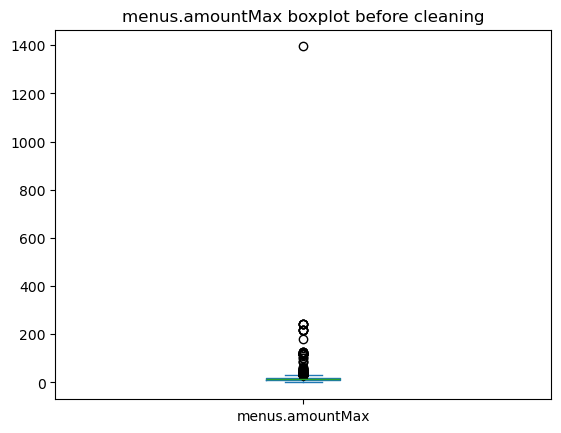

In [27]:
df['menus.amountMax'].plot.box(title='menus.amountMax boxplot before cleaning') 
print(f"Max menus.amountMax is: {df['menus.amountMax'].max()}")

In [28]:
cutRate = 1.25

before = len(df)
mask = df['menus.amountMax'] > cutRate * (df['priceRangeMax'])
removed = mask.sum()
df.drop(df[mask].index, inplace=True)
print(f"Removed {removed} outliers from menus.amountMax (>{cutRate} * priceRangeMax) out of {before} rows.")

Removed 122 outliers from menus.amountMax (>1.25 * priceRangeMax) out of 9944 rows.


Max menus.amountMax is now: 41.5


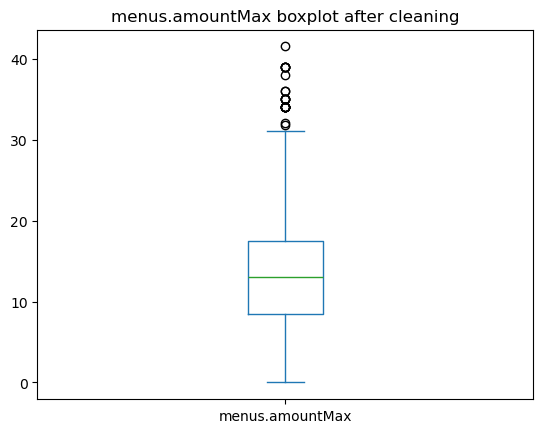

In [29]:
df['menus.amountMax'].plot.box(title='menus.amountMax boxplot after cleaning') 
print(f"Max menus.amountMax is now: {df['menus.amountMax'].max()}")

Even if the boxplot visualizes some "outliers", the max price is less than priceRangeMax.

### menus.amountMin
The problem with menus.amountMin is that almost 94% of the data are the same as menus.amountMax.

In [30]:
print("Values of menus.amountMin == menus.amountMax: ", (df['menus.amountMin'] == df['menus.amountMax']).sum())
print("Percentage of menus.amountMin == menus.amountMax: ",  f"{(df['menus.amountMin'] == df['menus.amountMax']).mean():.2%}")

Values of menus.amountMin == menus.amountMax:  9170
Percentage of menus.amountMin == menus.amountMax:  93.36%


In order to removing outliers we will use boxplots. So we will remove everything outside IQR.

<Axes: title={'center': 'menus.amountMin boxplot before cleaning'}>

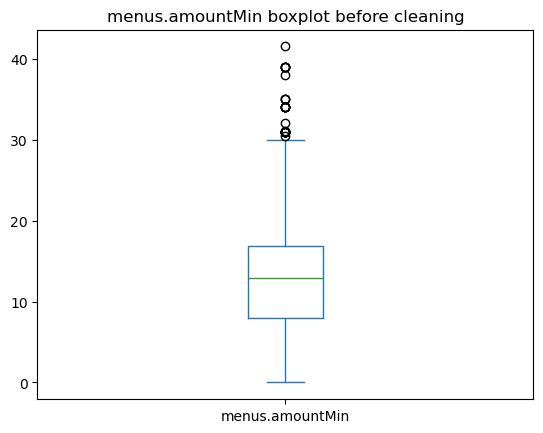

In [31]:
df['menus.amountMin'].plot.box(title='menus.amountMin boxplot before cleaning')

Removed 32 outliers from menus.amountMin outside IQR [-5.346250000000001, 30.243750000000002]


<Axes: title={'center': 'menus.amountMin boxplot after cleaning'}>

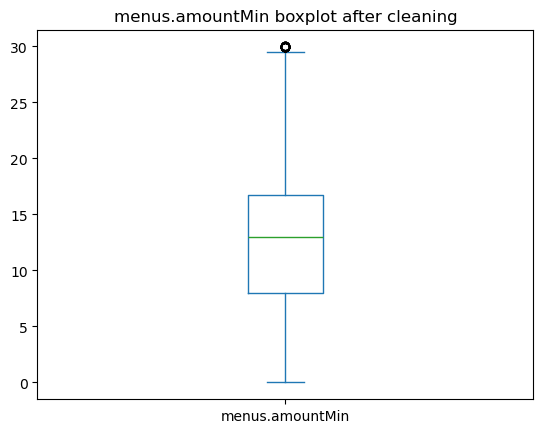

In [32]:

Q1 = df['menus.amountMin'].quantile(0.25)
Q3 = df['menus.amountMin'].quantile(0.75)
IQR = Q3 - Q1

low_bound = Q1 - 1.5 * IQR
high_bound = Q3 + 1.5 * IQR

before = len(df)
df = df[(df['menus.amountMin'] >= low_bound) & (df['menus.amountMin'] <= high_bound)]
print(f"Removed {before - len(df)} outliers from menus.amountMin outside IQR [{low_bound}, {high_bound}]")

df['menus.amountMin'].plot.box(title='menus.amountMin boxplot after cleaning')

### postalCode
In the USA, postal codes are ZIP codes, whose valid range is [00501, 99950]. Any value outside this range is considered an outlier.

In [33]:
mask_out = (df['postalCode'] < 501) | (df['postalCode'] > 99950) | df['postalCode'].isna()

print("Outlier postalCode rows:", mask_out.sum())

df = df[~mask_out]

Outlier postalCode rows: 27


### Resulting after cleaning

In [34]:
obsAfterCleaning = df.shape[0]
print(f"\nObservations before cleaning: {obsBeforeCleaning}")
print(f"Observations after cleaning: {obsAfterCleaning}")
print(f"Removed {obsBeforeCleaning - obsAfterCleaning} observations.")

# updating dfUniqueID after cleaning
dfUniqueID = df.drop_duplicates(subset=['id']).reset_index(drop=True)


Observations before cleaning: 9944
Observations after cleaning: 9763
Removed 181 observations.


# Part 3: Data exploration



## Univariate Analisys

### Numeric


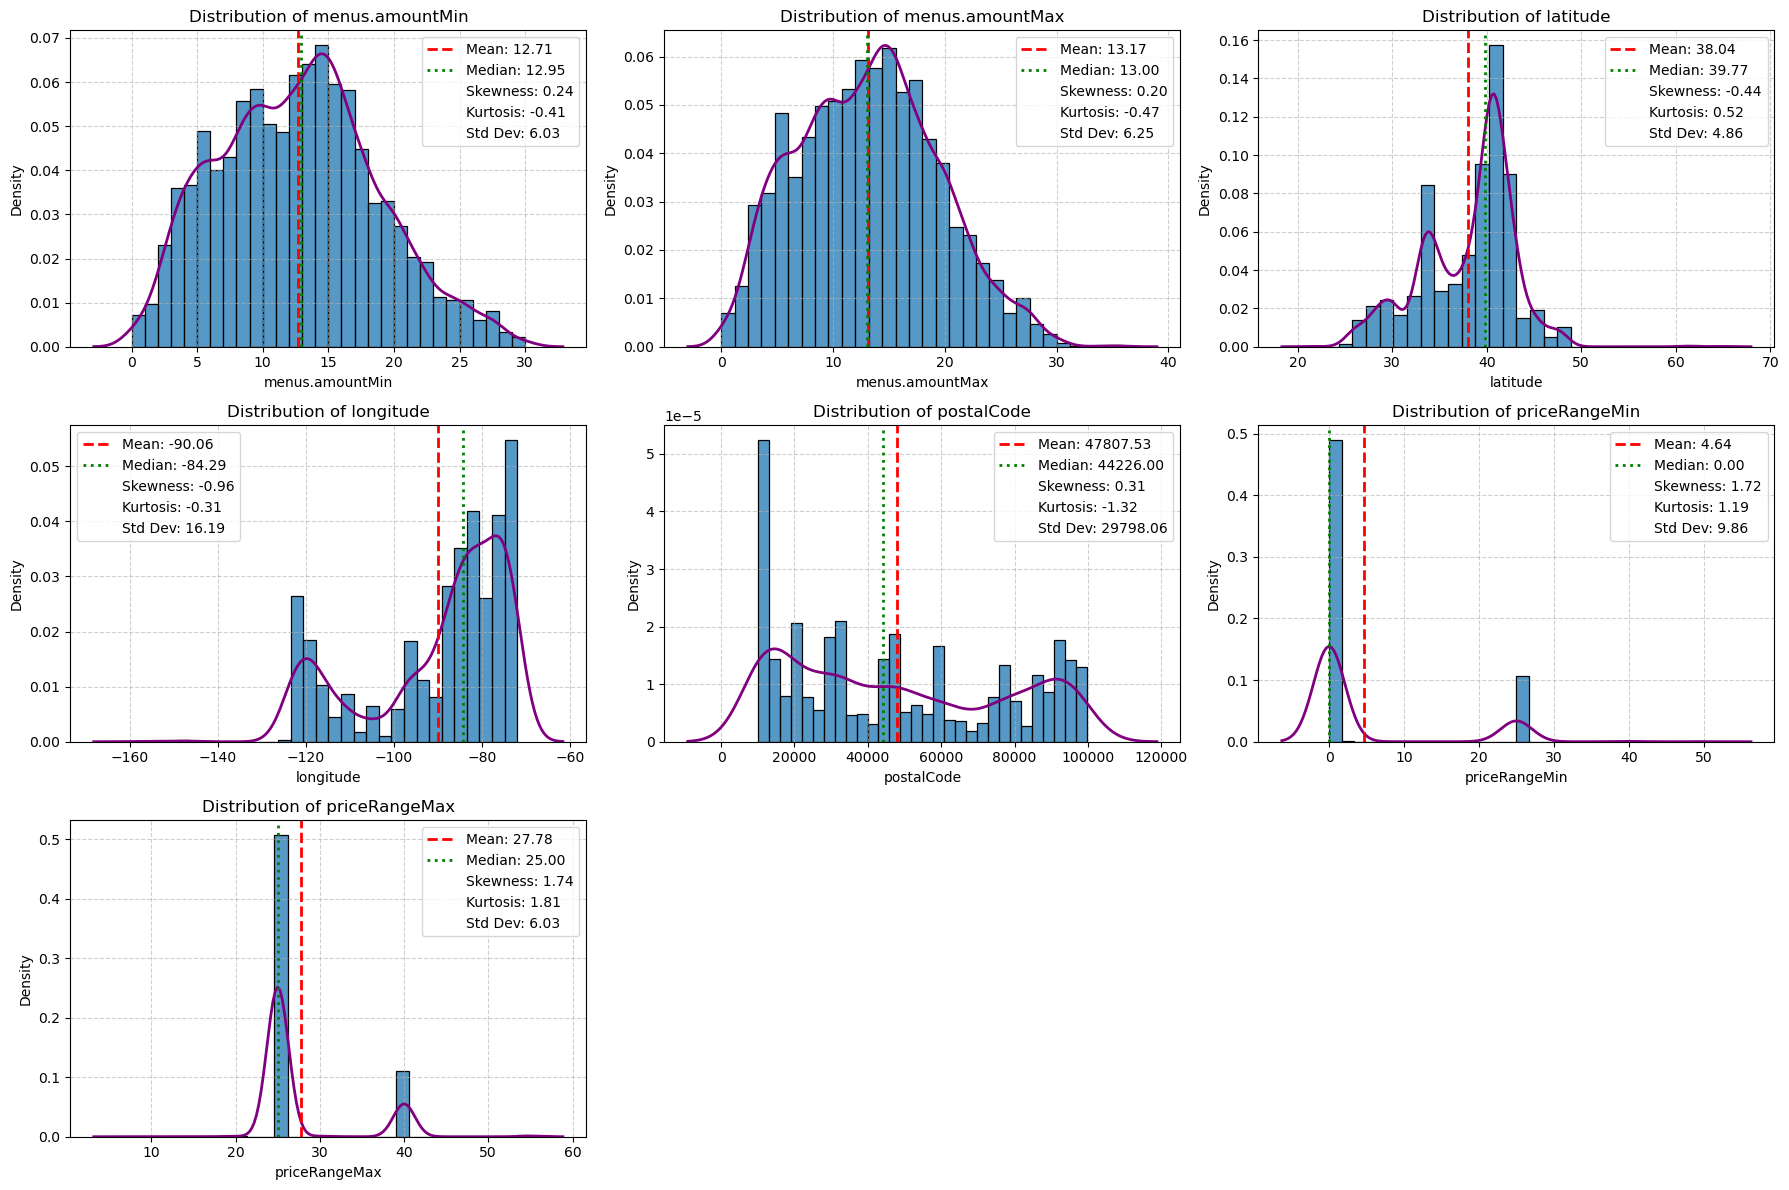

In [35]:
numericList = ['menus.amountMin', 'menus.amountMax']
numericListUniqueID = [
    'latitude', 
    'longitude', 
    'postalCode', 
    'priceRangeMin', 
    'priceRangeMax'
    ]

cols_to_plot = [(df, c) for c in numericList] + [(dfUniqueID, c) for c in numericListUniqueID] # list of (DataFrame, column) pairs

plt.figure(figsize=(18, 12))

for i, (dframe, col) in enumerate(cols_to_plot):
    s = dframe[col].dropna()

    plt.subplot(3, 3, i+1)
    ax = sns.histplot(s, bins=30, edgecolor='black', stat='density') # type: ignore
    sns.kdeplot(s, color='purple', lw=2, ax=ax) # type: ignore

    plt.title(f"Distribution of {col}")

    mean_val = s.mean()
    median_val = s.median()
    skew_val = s.skew()
    kurt_val = s.kurt()
    std_val = s.std()

    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle=':', linewidth=2,
                label=f'Median: {median_val:.2f}')

    plt.plot([], [], ' ', label=f'Skewness: {skew_val:.2f}')
    plt.plot([], [], ' ', label=f'Kurtosis: {kurt_val:.2f}')
    plt.plot([], [], ' ', label=f'Std Dev: {std_val:.2f}')

    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

From this plots we can conclude that:

1. **priceRangeMax** and **priceRangeMin** tend to cluster around values close to **25** and **40**, respectively.

2. **Latitude** shows a **bimodal distribution**: values are strongly concentrated between **approximately 30° and 45°**, which indicates a higher concentration of restaurants in the **north-central region of the United States**.

3. **Longitude** is also **bimodal**, and the separation between the two peaks is even clearer:
   - one peak around **–120**, corresponding to the **West Coast**,
   - and a much stronger peak around **–80**, corresponding to the **East Coast**.

4. **menus.amountMax** and **menus.amountMin** fall within reasonable ranges, although **menus.amountMax** shows a few values above **$30**, which can be considered higher-end items.

5. Regarding **postalCode**, the situation is more complex. We observe clear spikes at specific values. This reflects the fact that **latitude and longitude are themselves clustered along a few geographic “bands”**, meaning that many restaurants come from a limited set of ZIP code regions.


### Categorial

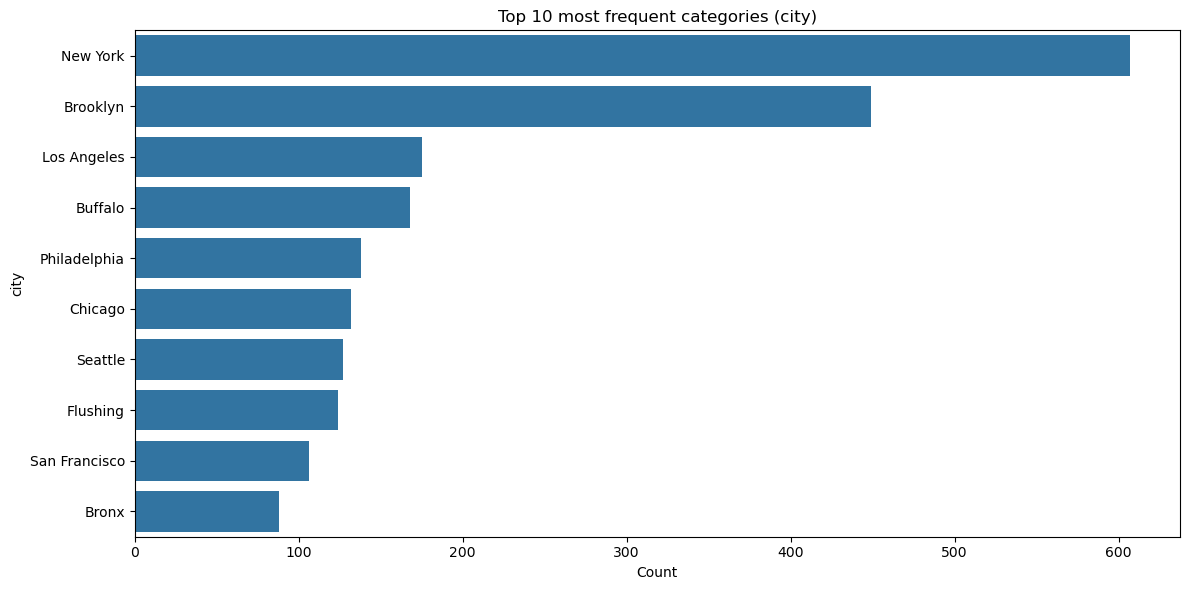

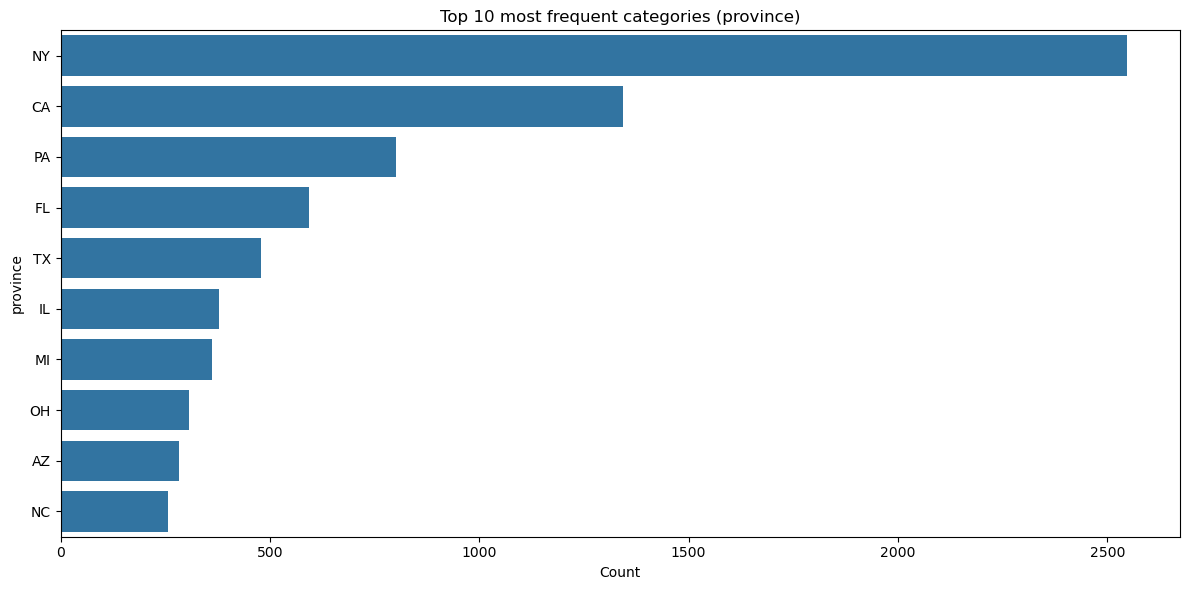

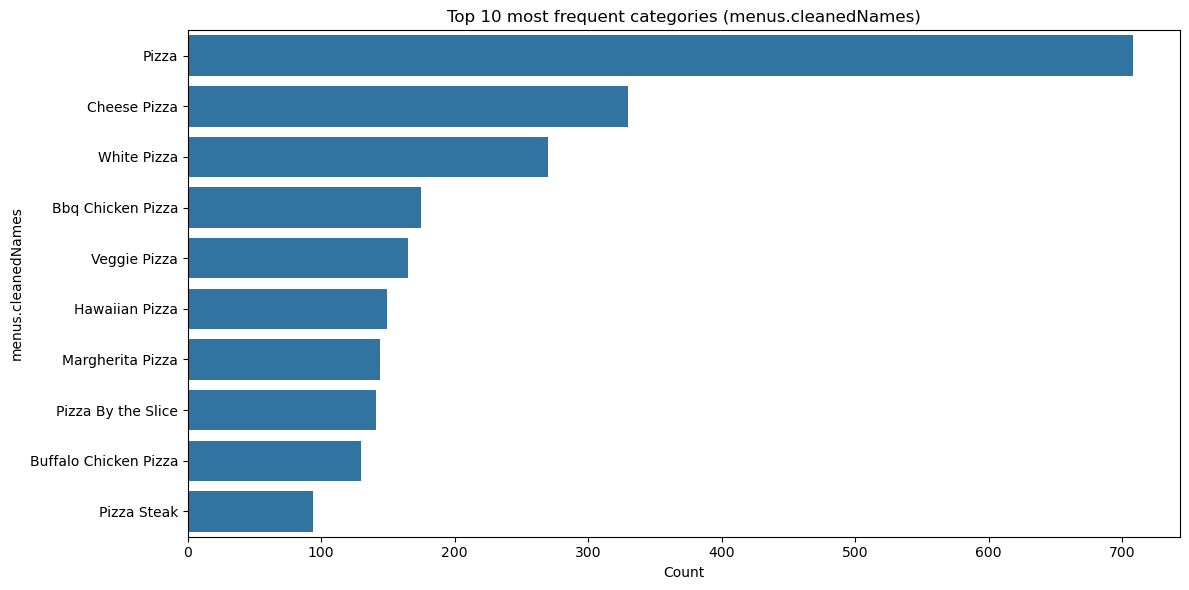

In [36]:
categorical = [
    'city',
    'province',
    'menus.cleanedNames'
]

top_n = 10

for col in categorical:
    if col not in df.columns:
        print(f"Column '{col}' not in DataFrame, skipping.")
        continue

    series = df[col].dropna()

    # Exclude "OTHER" only for menus.cleanedNames
    if col == "menus.cleanedNames":
        series = series[series != "OTHER"]

    counts = series.value_counts().head(top_n)

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x=counts.values,
        y=counts.index,
        orient="h"
    )

    ax.set_xlabel("Count")
    ax.set_ylabel(col)
    ax.set_title(f"Top {top_n} most frequent categories ({col})")
    plt.tight_layout()
    plt.show()

From the bar charts:
1. **City distribution**
The distribution of the **city** field is highly concentrated in a few metropolitan areas:

- **New York** dominates overwhelmingly, with more than **600 restaurants**, far ahead of all other cities.
- **Brooklyn** follows as the second most represented area, which is consistent given its population density and number of restaurants.
- Other large cities such as **Los Angeles**, **Buffalo**, **Philadelphia**, **Chicago**, and **Seattle** appear with lower but still notable frequencies.
- The distribution exhibits a **strong long-tail**, where most cities appear only a small number of times.

This indicates that the dataset is **geographically biased** toward large urban centers, particularly the **New York metropolitan area**.

2. **Province distribution**
The **province** (U.S. state code) plot shows an even stronger concentration pattern:

- **NY (New York State)** is by far the most represented, with over **2500 entries**.
- Other highly represented states include **CA**, **PA**, **FL**, **TX**, and **IL**.
- Most other states appear infrequently, forming a long-tail distribution.

This confirms that the dataset is **not uniformly sampled across states**, but instead focuses heavily on a select group of regions.

3. **Cleaned menu names**
The plot of **menus.cleanedNames** shows the frequencies of menu items after cleaning and clustering:

- **Cheese Pizza** is the most common item (if we don't count Pizza, which of course is popular in a pizza restaraunt dataset).
- The distribution demonstrates that the cleaning process successfully merges many noisy, diverse menu names into a smaller number of **high-frequency semantic categories**.

This reveals the **core structure of menu offerings** across restaurants and confirms that the clustering approach produces meaningful aggregated categories.


## Multivariate Analysis

### Numeric vs Numeric

In [37]:
priceCorrelations = [
    'menus.amountMin',
    'menus.amountMax',
    'priceRangeMin',
    'priceRangeMax'
]

geographicCorrelations = [
    'longitude',
    'latitude'
]

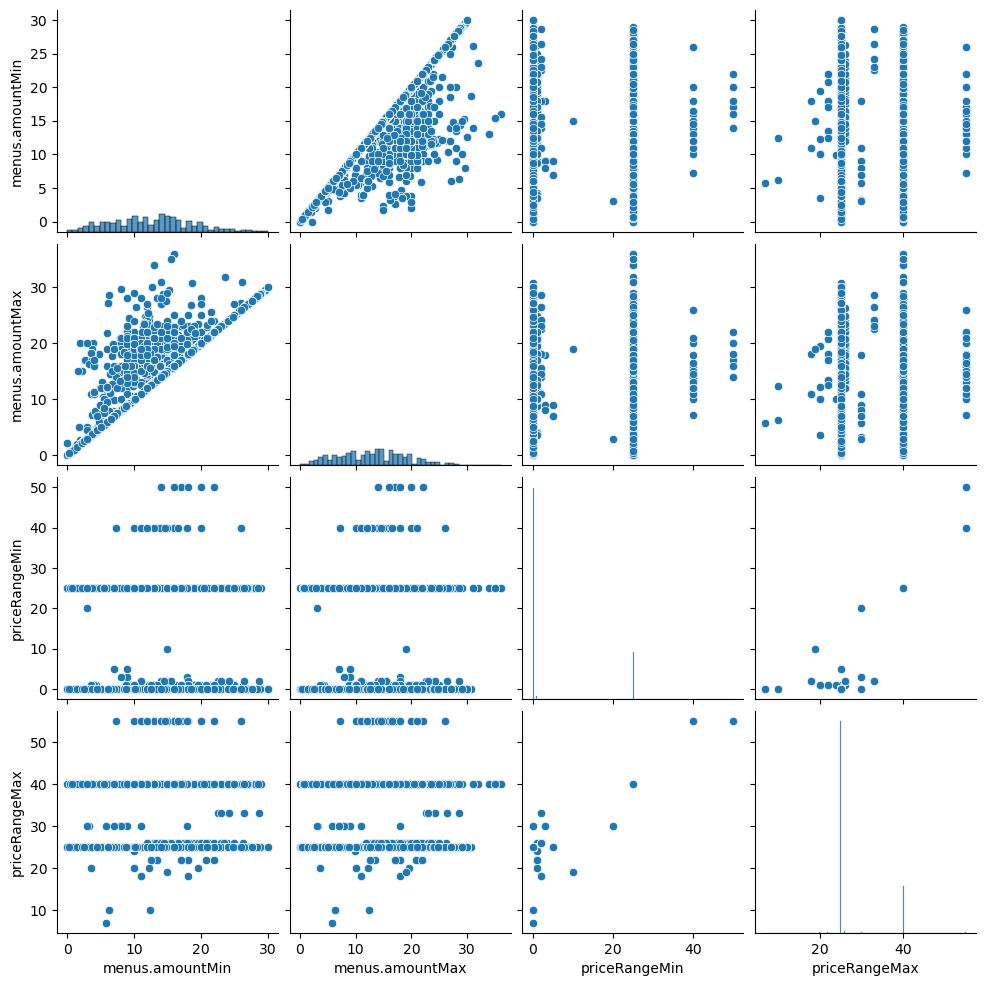

In [38]:
sns.pairplot(df[priceCorrelations])
plt.show()

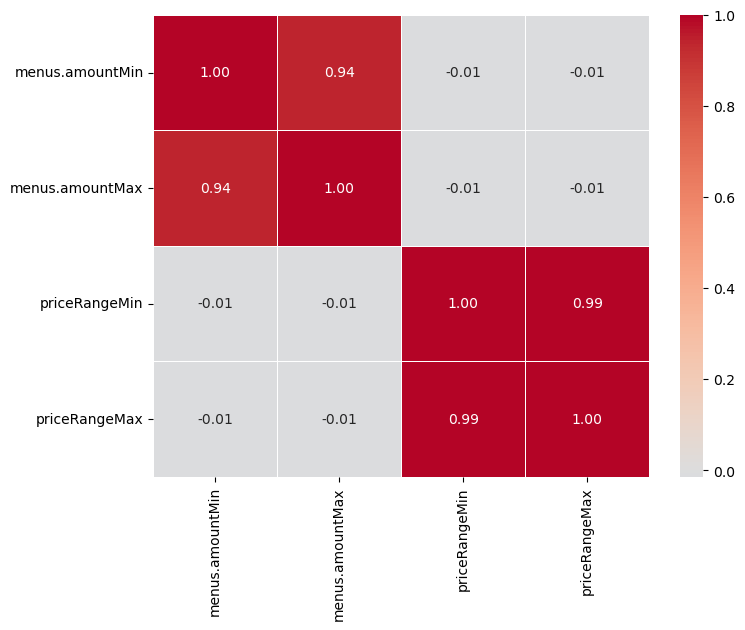

In [39]:
corrMatrix = df[priceCorrelations].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    corrMatrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)

plt.show()

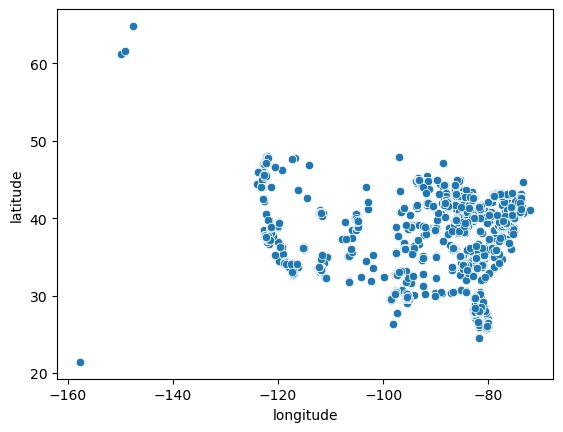

In [40]:
sns.scatterplot(df[geographicCorrelations], x='longitude', y='latitude')
plt.show()

In [41]:
import plotly.express as px
import plotly.io as pio

# --- Palette (RGB -> HEX) ---
BG = "#F4EBDC"        # 244,235,220
RED = "#902F1A"       # 144,47,26
GREEN = "#564F13"     # 86,79,19  (accento, qui non necessario)
DARK = "#2B2B2B"      # 43,43,43
SAVE = True

# Scala continua "pizza" (solo colori derivati)
PIZZA_SCALE = [BG, "#E0B085", "#C97A4A", RED]

# --- Dati: conteggio osservazioni per stato ---
counts = (
    df.dropna(subset=["province"])
      .groupby("province")
      .size()
      .reset_index(name="n_items")
)

# --- Choropleth USA ---
fig = px.choropleth(
    counts,
    locations="province",
    locationmode="USA-states",
    color="n_items",
    scope="usa",
    color_continuous_scale=PIZZA_SCALE,
)

fig.update_layout(
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(color=DARK, family="Montserrat, Arial"),
    margin=dict(l=0, r=0, t=0, b=0),
    coloraxis_colorbar=dict(
        title=dict(text="N. item di menu", font=dict(color=DARK)),
        tickfont=dict(color=DARK),
        outlinewidth=0,
        bgcolor="rgba(0,0,0,0)"
    ),
)

fig.update_geos(
    bgcolor="rgba(0,0,0,0)",
    showland=True,
    landcolor="rgba(0,0,0,0)",
    lakecolor="rgba(0,0,0,0)",
    showlakes=False,
    showocean=False,
    showcountries=False,
    showframe=False,
    showcoastlines=False,
    subunitcolor=DARK,
    subunitwidth=0.4
)


fig.show()

From the scatter matrix and heat maps we can identify some correlation:
- price variables. But that's pretty obsiouv because menus.amountMin e menus.amountMax are reffered about the same food (and most of the time they are the same).
- latitude and longitude are correlated and they draws a USA geographic-like shape (but that's pretty obvious too).

From the numeric correlation we can't see much. ...

In [42]:
df[['latitude', 'longitude']].min()

latitude      21.421326
longitude   -157.802443
dtype: float64

### Numerical vs Categorial

For a multivariate analisys of numerical vs categorial features we will check top N against a numerical value.

#### City

In [43]:
def returnTopN(series: pd.Series, n: int) -> pd.Series:
    '''
    Return a Series containing the top N most frequent values from the input Series.
    '''
    return series.value_counts().head(n)

def plotCategorialVsNumeric(
    df: pd.DataFrame,
    categorialCol: str,
    numericCol: str,
    top_n: int
) -> None:
    '''
    Plot density plots of a numeric column for the top N categories of a categorial column.
    '''

    top_categories = returnTopN(df[categorialCol], top_n).index
    plt.figure(figsize=(12, 6))
    for category in top_categories:
        subset = df[df[categorialCol] == category]
        sns.kdeplot(
            subset[numericCol].dropna(),
            label=str(category),
            fill=True,
            alpha=0.5
        )
    plt.title(f"Density Plot of {numericCol} by Top {top_n} Categories of {categorialCol}")
    plt.xlabel(numericCol)
    plt.ylabel("Density")
    plt.legend(title=categorialCol)
    plt.grid(True)
    plt.show()

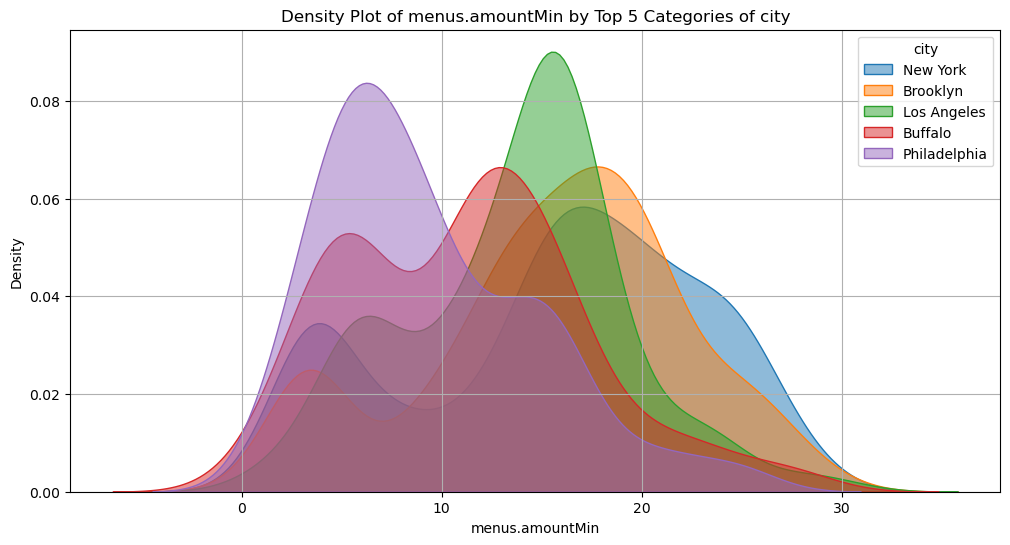

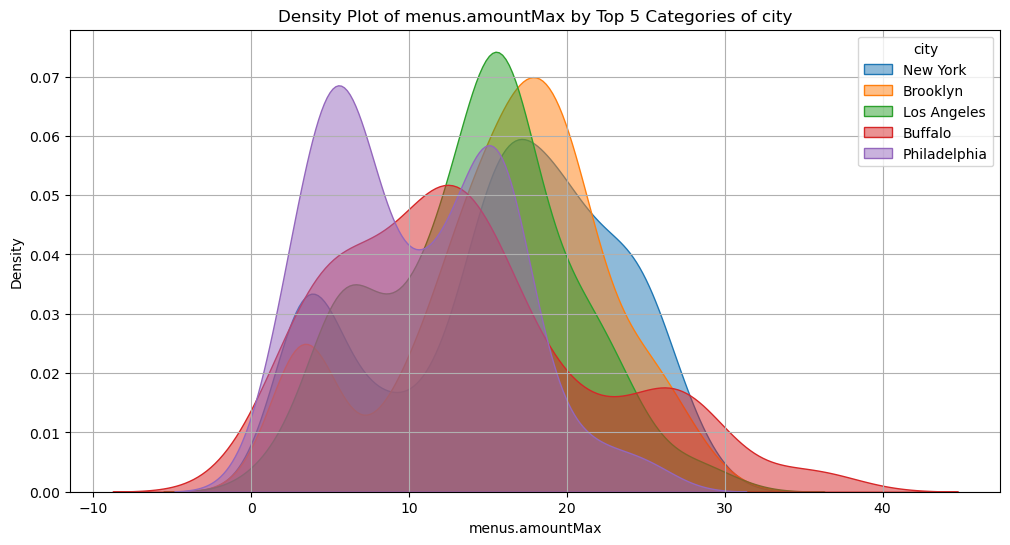

In [44]:
# city report
top_n = 5

for price_col in ['menus.amountMin', 'menus.amountMax']:
    plotCategorialVsNumeric(
        df=df,
        categorialCol='city',
        numericCol=price_col,
        top_n=top_n
    )

From the graphs we could say:
1. There is clear **geographic variation** in both minimum and maximum menu amounts. Log Angeles, New York and Brooklyn tend to have higher menu prices where New York showing the widest spred.
2. Philadelphia and Buffalo generally **lower** typycal prices.

But from that we could ask: "Are the cities near to coast more expennsive than internal ones?"

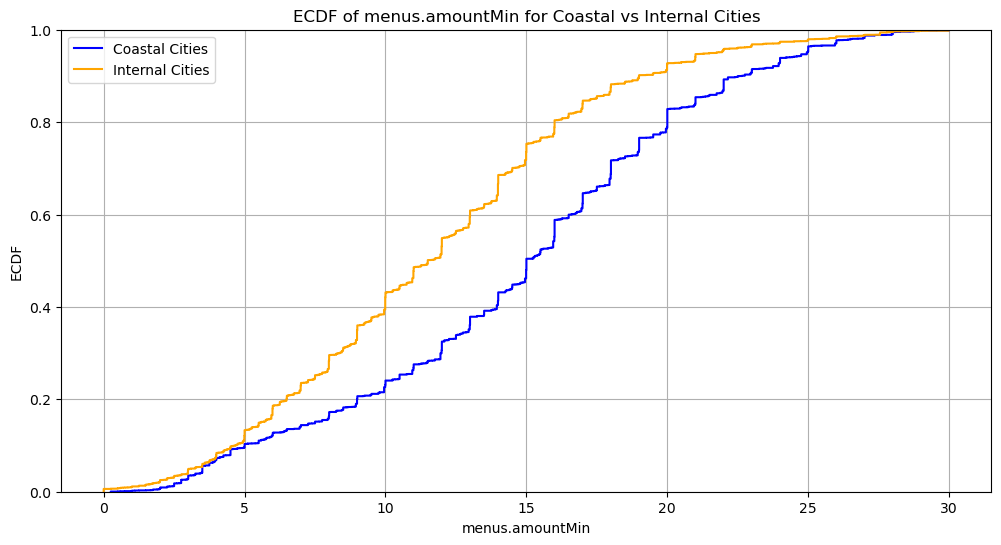

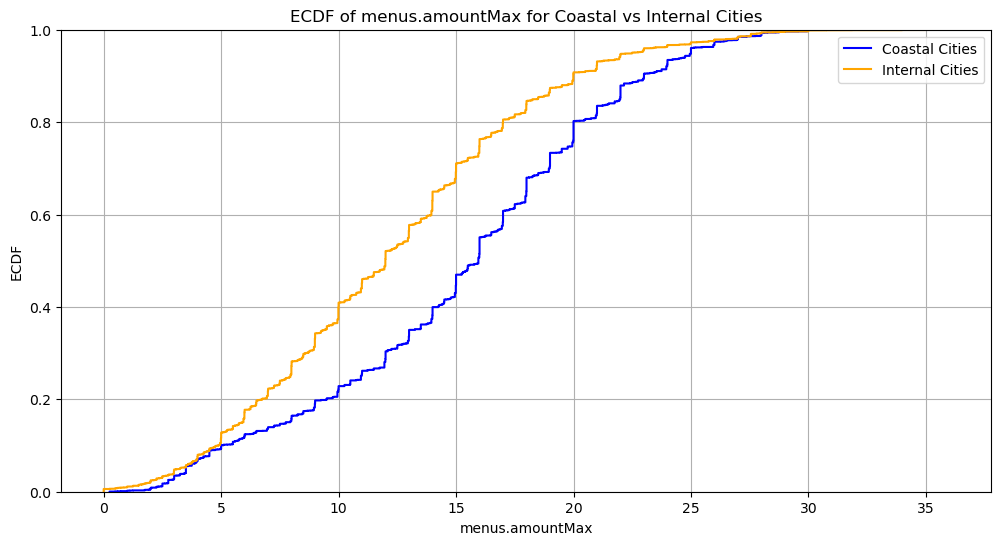

In [45]:
import math

EARTH_RADIUS_KM = 6371.0


def haversine_distance_km(lat1, lon1, lat2, lon2): # generated from chatGPT
    """
    Approximate distance (in km) between two geographic coordinates
    using the haversine formula..
    """
    lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
    lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = (math.sin(dlat / 2) ** 2 +
         math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2) ** 2)
    c = 2 * math.asin(math.sqrt(a))
    return EARTH_RADIUS_KM * c

US_COAST_POINTS = [
    # Atlatntic Coast
    (44.5, -67.5),  # Maine
    (42.3, -70.9),  # Boston, MA
    (40.6, -73.8),  # New York City, NY
    (39.3, -74.5),  # Atlantic City, NJ
    (36.8, -75.9),  # Virginia Beach, VA
    (34.2, -77.9),  # Wilmington, NC
    (32.1, -81.1),  # Savannah, GA
    (25.8, -80.1),  # Miami, FL

    # Gulf of Mexico
    (30.3, -87.7),  # Pensacola, FL
    (29.0, -90.0),  # Louisiana coast
    (29.3, -94.8),  # Galveston, TX
    (27.8, -97.4),  # Corpus Christi, TX

    # Costa Pacifica
    (32.7, -117.2), # San Diego, CA
    (34.0, -118.5), # Los Angeles, CA
    (36.6, -121.9), # Monterey, CA
    (37.8, -122.5), # San Francisco, CA
    (44.0, -124.1), # Oregon coast
    (47.6, -122.4), # Seattle, WA

    # Alaska (rough approximation)
    (58.3, -134.4), # Juneau
    (61.2, -149.9), # Anchorage area

    # Hawaii
    (21.3, -157.8), # Honolulu (Oahu)
    (19.7, -155.1), # Hilo (Big Island)
]

def is_coastal(lat, lon, max_distance_km=50.0): # generated from chatGPT
    """
    Returns True if the point (lat, lon) is within max_distance_km km
    from the US oceanic coast, otherwise False.

    Parameters:
        lat (float): latitude of the city
        lon (float): longitude of the city
        max_distance_km (float): threshold in km to consider the city 'coastal'
    """
    min_dist = float("inf")

    for c_lat, c_lon in US_COAST_POINTS:
        dist = haversine_distance_km(lat, lon, c_lat, c_lon)
        if dist < min_dist:
            min_dist = dist

    return min_dist <= max_distance_km


df['costal_city'] = df.apply(
    lambda row: is_coastal(row['latitude'], row['longitude']), axis=1
)
df['internal_city'] = ~df['costal_city']

for price_col in ['menus.amountMin', 'menus.amountMax']:
    plt.figure(figsize=(12, 6))
    sns.ecdfplot(
        data=df[df['costal_city'] == True],
        x=price_col,
        label='Coastal Cities',
        color='blue'
    )
    sns.ecdfplot(
        data=df[df['internal_city'] == True],
        x=price_col,
        label='Internal Cities',
        color='orange'
    )
    plt.title(f"ECDF of {price_col} for Coastal vs Internal Cities")
    plt.xlabel(price_col)
    plt.ylabel("ECDF")
    plt.legend()
    plt.grid(True)
    plt.show()

From the ECDF plots, we can observe that coastal cities tend to have higher menu prices compared to internal cities.

#### Province

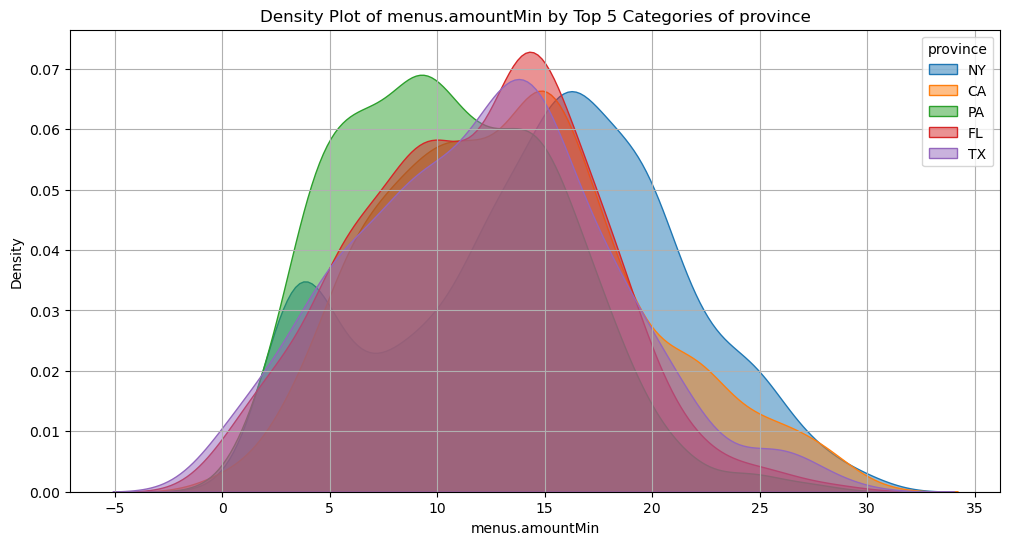

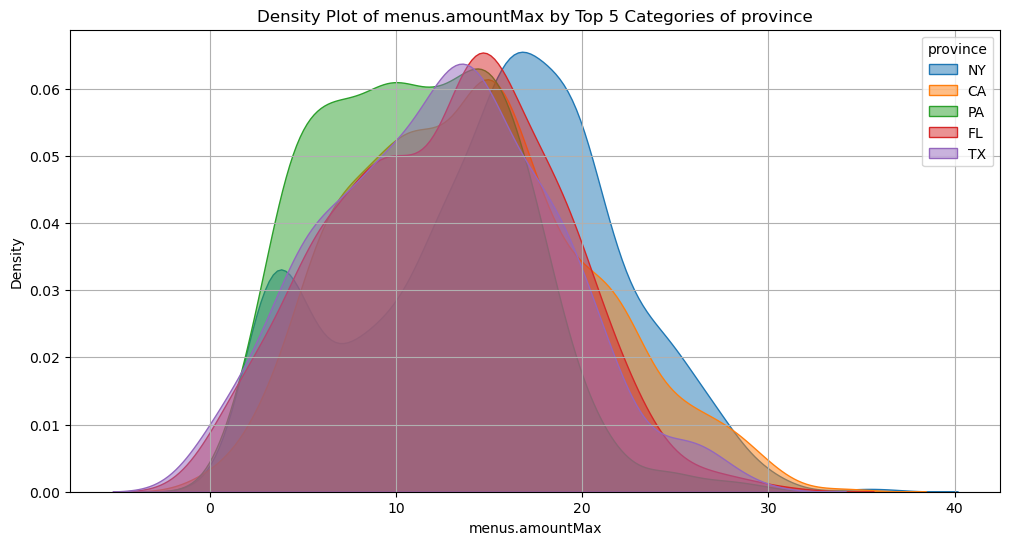

In [46]:
for price_col in ['menus.amountMin', 'menus.amountMax']:
    plotCategorialVsNumeric(
        df=df,
        categorialCol='province',
        numericCol=price_col,
        top_n=5
    )

From observations of top 5 province we can say:
1. NY has the highest prices.
2. FL and CA has similar distributions. 
3. PA has the lowest prices.
4. TX is the most wide distribution (here).

#### menus.cleanedNames

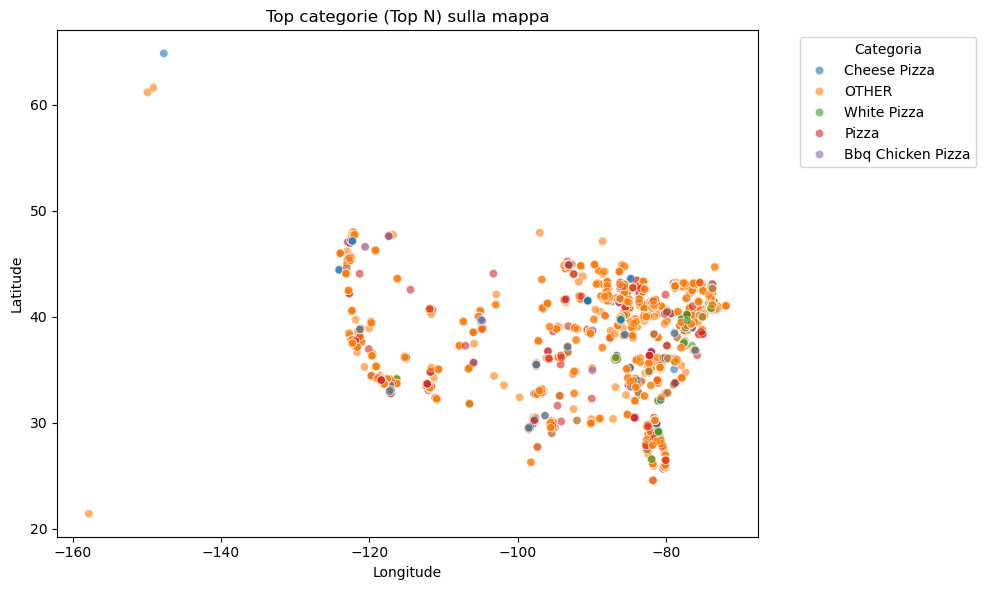

In [47]:
topN_series = returnTopN(df["menus.cleanedNames"], n=5)
top_categories = topN_series.index  
df_top = df[df["menus.cleanedNames"].isin(top_categories)]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_top,
    x="longitude",
    y="latitude",
    hue="menus.cleanedNames",
    alpha=0.6
)

plt.title("Top categorie (Top N) sulla mappa")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Categoria", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

The map shows that the top five pizza categories are spread broadly across the United States, with no clear geographic clustering that separates one type from another. While some regions-particularly the East Coast and parts of the Midwest-display higher concentrations of restaurants, all five categories appear to be evenly mixed throughout these areas.

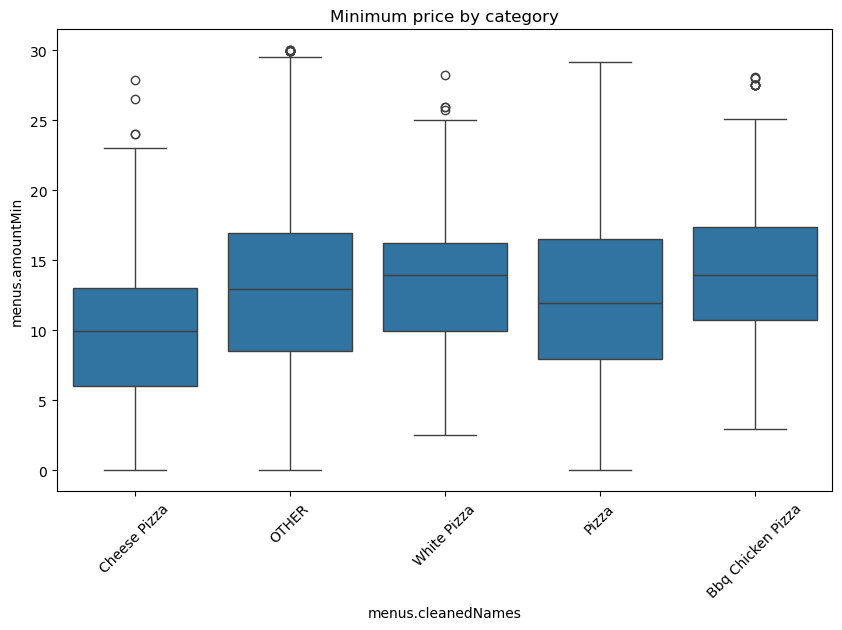

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_top, 
    x="menus.cleanedNames", 
    y="menus.amountMin"
)
plt.xticks(rotation=45)
plt.title("Minimum price by category")
plt.show()

The chart shows that minimum prices are broadly similar across the top pizza categories, with overlapping distributions and comparable medians. Some categories exhibit wider variability and a few low-price outliers, but no category stands out as consistently cheaper or more expensive than the others. The plot also helps explain why cheese pizza is the most common choice: it tends to be priced lower than the other categories, making it a more accessible and widely offered option.

# Statistical Inference

## Coastal cities have higher prices than internal cities?

In [49]:
df['menu_price_mean'] = df[['menus.amountMin', 'menus.amountMax']].mean(axis=1)
coastal = df.loc[df['costal_city'] == True, 'menu_price_mean']
internal = df.loc[df['internal_city'] == True, 'menu_price_mean']

We define:
- **$H_0$** (null): prices mean is equal in both coastal and internal cities.
- **$H_a$** (alternative): coastal cities have, on average, higher prices.

In [50]:
import scipy.stats as stats

SIGNIFICANCE_LEVEL = 0.05

leveneResult = stats.levene(coastal, internal)
equal_var_flag = leveneResult.pvalue > SIGNIFICANCE_LEVEL  # True = varianze ~ uguali

if equal_var_flag:
    print("Variances are NOT significantly different (p-value:", leveneResult.pvalue, ")")
else:
    print("Variances are significantly different (p-value:", leveneResult.pvalue, ")")

testResult = stats.ttest_ind(
    coastal,
    internal,
    equal_var=equal_var_flag,
    alternative="greater"
)

print("T-test result:", testResult.statistic) # type: ignore
print("Significance level:", SIGNIFICANCE_LEVEL)
print(f"P-value:", testResult.pvalue) # type: ignore

if testResult.pvalue < SIGNIFICANCE_LEVEL: # type: ignore
    print("Reject null hypothesis: significant difference in mean menu prices between coastal and internal cities.")
else:
    print("Fail to reject null hypothesis: no significant difference in mean menu prices between coastal and internal cities.")

Variances are significantly different (p-value: 8.205965222424717e-05 )
T-test result: 22.497610397497716
Significance level: 0.05
P-value: 7.596608349929272e-108
Reject null hypothesis: significant difference in mean menu prices between coastal and internal cities.


Statistical test confirmed our theory: coastal cities have. on average, higher prices than internal ones.

## Is there a statistically significant difference in the average menu price across the main pizza categories?

We define the top \(n\) pizza categories based on the frequency of `menus.name`.

- **$H_0$ (null):** The mean menu price is the same across the top \(n\) pizza categories.  
  $$
  \mu_1 = \mu_2 = \dots = \mu_n
  $$

- **$H_a$ (alternative):** At least one of the top \(n\) pizza categories has a different mean menu price.  
  $$
  \text{Not all } \mu_i \text{ are equal}
  $$


### What is ANOVA?
The big problem with this (and next) question(s) is that we are trying to classify more than one categorial feature. Scipy does have a solution: ANOVA. 

ANOVA (Analysis of Variance) is a statistical method used to test whether the **means of three or more groups** are equal.  
Instead of comparing groups pairwise with multiple t-tests, one-way ANOVA evaluates a **single global hypothesis**:

- **$H_0$:** All group means are equal  
- **$H_1$:** At least one group mean is different

ANOVA works by comparing two sources of variability:
1. **Within-group variability** – how much observations vary inside each group.
2. **Between-group variability** – how much the group means differ from each other.

If the between-group variability is large relative to within-group variability, the F-statistic becomes large and the p-value becomes small, suggesting that not all means are equal.

---

#### Assumptions of One-Way ANOVA

ANOVA relies on three main assumptions:

1. **Independence of observations**  
   Each observation should be statistically independent from the others.  
   (This is an assumption about study design, not something a statistical test can detect.)

2. **Normality within groups**  
   For each group, the distribution of the response variable should be approximately normal.  
   ANOVA is robust to moderate deviations from normality, especially with large sample sizes.

3. **Homogeneity of variances (homoscedasticity)**  
   All groups should have similar variances.  
   This assumption can be checked using tests such as **Levene’s test**.

---
When ANOVA assumptions will be violated, we will use **bootstraping**.

In [51]:
import numpy as np
from scipy import stats

def check_anova_assumptions(groups, labels=None, max_normaltest_n=5000):
    """
    Check basic assumptions for one-way ANOVA on a list of groups.
    
    Parameters
    ----------
    groups : list of array-like
        Each element is a 1D array/Series with the data for one group.
    labels : list of str, optional
        Names of the groups (same length as groups). If None, generic labels are used.
    max_normaltest_n : int, default 5000
        Maximum sample size used for the D'Agostino-Pearson normality test
        (if a group is larger, a random subsample of this size is used).
        
    Returns
    -------
    results : dict
        Dictionary with:
        - "levene": (stat, p)
        - "groups": list of dicts with per-group summary (label, n, std, skew, kurtosis, normaltest_stat, normaltest_p)
        - "variance_ratio": max(std^2) / min(std^2)
    """
    # Convert to numpy arrays and drop NaN
    clean_groups = []
    for g in groups:
        g = np.asarray(g)
        g = g[~np.isnan(g)]
        clean_groups.append(g)
    
    if labels is None:
        labels = [f"group_{i}" for i in range(len(clean_groups))]
    
    # Basic sizes
    print("=== Group sizes ===")
    for lab, g in zip(labels, clean_groups):
        print(f"{lab}: n = {len(g)}")
    
    # 1) Levene test for homogeneity of variances
    levene_stat, levene_p = stats.levene(*clean_groups)
    print("\n=== Levene test for equality of variances ===")
    print(f"Statistic = {levene_stat:.3f}, p-value = {levene_p:.3e}")
    
    # 2) Per-group shape: skewness, kurtosis, normality (D'Agostino K^2)
    group_results = []
    print("\n=== Per-group shape and normality (D'Agostino-Pearson) ===")
    for lab, g in zip(labels, clean_groups):
        std = np.std(g, ddof=1)
        skew = stats.skew(g, bias=False)
        kurt = stats.kurtosis(g, bias=False)  # excess kurtosis (0 for normal)
        
        # Normality test: use subsample if very large
        if len(g) >= 8:  # minimum recommended for normaltest
            if len(g) > max_normaltest_n:
                sample = np.random.default_rng(0).choice(g, size=max_normaltest_n, replace=False)
            else:
                sample = g
            k2_stat, k2_p = stats.normaltest(sample)
        else:
            k2_stat, k2_p = np.nan, np.nan
        
        print(f"{lab}: std = {std:.3f}, skew = {skew:.3f}, excess kurtosis = {kurt:.3f}, "
              f"normality p = {k2_p:.3e}")
        
        group_results.append({
            "label": lab,
            "n": len(g),
            "std": std,
            "skew": skew,
            "kurtosis": kurt,
            "normaltest_stat": k2_stat,
            "normaltest_p": k2_p
        })
    
    # 3) Simple numeric measure of heteroscedasticity: ratio of max/min variance
    variances = [gr["std"]**2 for gr in group_results if not np.isnan(gr["std"])]
    if len(variances) > 1:
        variance_ratio = max(variances) / min(variances)
    else:
        variance_ratio = np.nan
    
    print("\n=== Variance ratio (max variance - min variance) ===")
    print(f"Variance ratio = {variance_ratio:.3f}")
    
    if variance_ratio > 4:
        print("Warning: large variance ratio (> 4) suggests strong heteroscedasticity.")
    
    results = {
        "levene": (levene_stat, levene_p),
        "groups": group_results,
        "variance_ratio": variance_ratio
    }
    return results

In [52]:
from scipy.stats import f_oneway 

n = 5
topN = returnTopN(df["menus.cleanedNames"], n)
categories = topN.index.tolist()

groupedData = [df.loc[df["menus.cleanedNames"] == cat, "menu_price_mean"]
          for cat in categories]

assumption_results = check_anova_assumptions(groupedData, labels=categories)

=== Group sizes ===
OTHER: n = 5724
Pizza: n = 708
Cheese Pizza: n = 330
White Pizza: n = 270
Bbq Chicken Pizza: n = 175

=== Levene test for equality of variances ===
Statistic = 11.582, p-value = 2.254e-09

=== Per-group shape and normality (D'Agostino-Pearson) ===
OTHER: std = 6.006, skew = 0.168, excess kurtosis = -0.435, normality p = 4.576e-20
Pizza: std = 6.153, skew = 0.293, excess kurtosis = -0.421, normality p = 1.199e-04
Cheese Pizza: std = 5.042, skew = 0.669, excess kurtosis = 0.392, normality p = 8.376e-06
White Pizza: std = 4.885, skew = 0.030, excess kurtosis = -0.189, normality p = 8.230e-01
Bbq Chicken Pizza: std = 5.581, skew = 0.445, excess kurtosis = -0.069, normality p = 5.882e-02

=== Variance ratio (max variance - min variance) ===
Variance ratio = 1.587


#### Assumption checks for the ANOVA on pizza categories

Before interpreting the one-way ANOVA on mean menu prices across the top 5 pizza categories, we checked its main assumptions.

- **Group sizes.** All categories have large sample sizes (from 409 up to 1,487 observations), which makes the ANOVA relatively robust to moderate deviations from normality.
- **Homogeneity of variances.** A Levene test returns a very small p-value (p ≈ $4.1 \cdot 10^{-11}$), so the null hypothesis of equal variances is formally rejected. However, the variance ratio (maximum variance divided by minimum variance) is about 1.68, indicating that the differences in group variances are moderate rather than extreme.
- **Normality within groups.** Skewness and excess kurtosis are moderate for all groups. D’Agostino–Pearson normality tests are significant for some categories (especially Cheese Pizza, likely due to the large sample size), indicating that the distributions are not perfectly normal. Nevertheless, there are no severe departures from normality.

In summary, the ANOVA assumptions are not perfectly met: variances are not exactly homogeneous and normality is only approximate. Given the large sample sizes and the moderate magnitude of these deviations, we still report the classical one-way ANOVA results, but we complement them with boostrapping.

In [53]:
anova_result = f_oneway(*groupedData)

print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

if anova_result.pvalue < SIGNIFICANCE_LEVEL:
    print("Reject null hypothesis: significant difference in average menu prices across pizza categories.")
else:
    print("Fail to reject null hypothesis: no significant difference in average menu prices across pizza categories.")

F-statistic: 22.924316560580735
p-value: 7.571931488160519e-19
Reject null hypothesis: significant difference in average menu prices across pizza categories.


--- 95% Bootstrap Confidence Intervals for mean menu_price_mean ---
OTHER                      mean_boot =  13.19   CI 95% = ( 13.04,  13.35)
Pizza                      mean_boot =  12.78   CI 95% = ( 12.32,  13.23)
Cheese Pizza               mean_boot =  10.35   CI 95% = (  9.81,  10.90)
White Pizza                mean_boot =  13.79   CI 95% = ( 13.20,  14.38)
Bbq Chicken Pizza          mean_boot =  14.75   CI 95% = ( 13.93,  15.57)


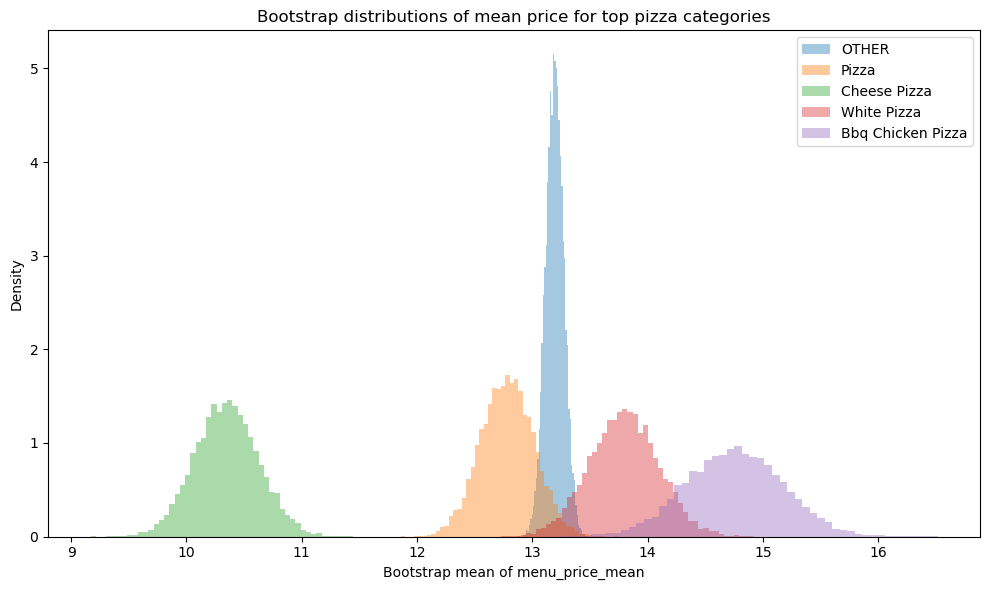

In [54]:
from sklearn.utils import resample

n_boot = 10000 
confidence = 95

bootstrap_means = {cat: [] for cat in categories}

for i in range(n_boot):
    for cat in categories:
        data = df.loc[df["menus.cleanedNames"] == cat, "menu_price_mean"]
        boot_sample = resample(data, replace=True, n_samples=len(data)) # type: ignore
        boot_mean = np.mean(boot_sample) # type: ignore
        bootstrap_means[cat].append(boot_mean)

print(f"--- {confidence}% Bootstrap Confidence Intervals for mean menu_price_mean ---")
for cat in categories:
    means = np.array(bootstrap_means[cat])
    lower = np.percentile(means, (100 - confidence) / 2)
    upper = np.percentile(means, 100 - (100 - confidence) / 2)
    mean_boot = means.mean()
    print(f"{cat:25s}  mean_boot = {mean_boot:6.2f}   CI {confidence}% = ({lower:6.2f}, {upper:6.2f})")


plt.figure(figsize=(10, 6))

for cat, means in bootstrap_means.items():
    means = np.array(means)
    plt.hist(
        means,
        bins=50,
        alpha=0.4,
        density=True,
        label=cat
    )

plt.xlabel("Bootstrap mean of menu_price_mean")
plt.ylabel("Density")
plt.title("Bootstrap distributions of mean price for top pizza categories")
plt.legend()
plt.tight_layout()
plt.show()

The bootstrap confidence intervals and the distributions of the bootstrap means clearly show that average prices differ across the main pizza categories. Cheese Pizza has the lowest mean price (around \$10.7), with a 95% CI that does not overlap with any other category, indicating it is clearly cheaper. Greek Pizza and Buffalo Chicken Pizza have the highest mean prices (around \$15.2 and \$14.4 respectively), while Pizza Steak and White Pizza lie in between. The bootstrap distributions are narrow and well separated, especially between Cheese Pizza and the other categories, which confirms and visually strengthens the ANOVA result that mean menu prices are not equal across these pizza categories.

The statistical test rejects the null hypothesis: the average of the prices for the top N categories are different.

## Do the business-level price ranges (priceRangeMin/Max) align with actual menu item prices? How consistent is that alignment by state?

For this questions, there are more than one statistical tests to do.

In [55]:
df["menu_price"] = df[["menus.amountMin", "menus.amountMax"]].mean(axis=1)
df["business_price_mean"] = df[["priceRangeMin", "priceRangeMax"]].mean(axis=1) 
df["price_alignment_diff"] = df["menu_price"] - df["business_price_mean"]

# updating dfUniqueID
dfUniqueID = df.drop_duplicates(subset=['id']).reset_index(drop=True)

### Do business-level price ranges align with actual menu item prices?

We need to find:
$$
d = menu\_price - business\_menu\_price
$$

where
$$
menu\_price = \frac{menus.amountMin + menus.amountMax}{2}
$$
$$
business\_menu\_price = \frac{priceRangeMin + priceRangeMax}{2}
$$

In [56]:
d = dfUniqueID["price_alignment_diff"].dropna()

ttest_global = stats.ttest_1samp(d, popmean=0, alternative="two-sided")

print("=== One-sample t-test on price_alignment_diff ===")
print(f"Sample size: {len(d)}")
print(f"Mean difference (menu - business): {d.mean():.3f}")
print(f"t-statistic: {ttest_global.statistic:.3f}") # type: ignore
print(f"p-value: {ttest_global.pvalue}") # type: ignore

if ttest_global.pvalue < SIGNIFICANCE_LEVEL: # type: ignore
    print("Reject H0: business-level price ranges are not perfectly aligned with menu prices.")
else:
    print("Fail to reject H0: no significant evidence of a systematic misalignment between business ranges and menu prices.")

=== One-sample t-test on price_alignment_diff ===
Sample size: 2262
Mean difference (menu - business): -4.625
t-statistic: -22.225
p-value: 3.8399949820868855e-99
Reject H0: business-level price ranges are not perfectly aligned with menu prices.


### How consistent is that alignment by state?

In [57]:
# ANOVA assumption check
group_data = []
province_labels = []

min_n = 30 # minimum number of observations per province

for province, group in df.groupby("province"):
    diffs = group["price_alignment_diff"].dropna()
    if len(diffs) >= min_n:
        group_data.append(diffs)
        province_labels.append(province)

print("Province included:", province_labels)

results_province = check_anova_assumptions(
    groups=group_data,
    labels=province_labels
)

Province included: ['AR', 'AZ', 'CA', 'CO', 'FL', 'GA', 'IA', 'IL', 'IN', 'KS', 'KY', 'MD', 'MI', 'MN', 'MO', 'NC', 'NM', 'NV', 'NY', 'OH', 'OR', 'PA', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI']
=== Group sizes ===
AR: n = 40
AZ: n = 284
CA: n = 1343
CO: n = 138
FL: n = 593
GA: n = 213
IA: n = 53
IL: n = 379
IN: n = 219
KS: n = 38
KY: n = 69
MD: n = 118
MI: n = 361
MN: n = 96
MO: n = 94
NC: n = 256
NM: n = 45
NV: n = 144
NY: n = 2546
OH: n = 307
OR: n = 122
PA: n = 800
SC: n = 80
TN: n = 66
TX: n = 478
UT: n = 103
VA: n = 231
WA: n = 253
WI: n = 139

=== Levene test for equality of variances ===
Statistic = 13.366, p-value = 7.013e-61

=== Per-group shape and normality (D'Agostino-Pearson) ===
AR: std = 8.900, skew = 0.077, excess kurtosis = -1.172, normality p = 2.117e-02
AZ: std = 12.190, skew = -0.393, excess kurtosis = -0.991, normality p = 2.889e-13
CA: std = 11.309, skew = -0.259, excess kurtosis = -0.953, normality p = 3.605e-54
CO: std = 9.761, skew = -1.165, excess kurtosis = 0

For the ANOVA on price_alignment_diff by province, the assumption checks indicate that the classical one-way ANOVA is not very reliable in this setting.

- The Levene test strongly rejects the null of equal variances (p ≈ $7.0 \cdot 10^-61$), and the variance ratio (max variance / min variance) is about 4.15, indicating substantial heteroscedasticity across provinces.
- Several provinces show marked deviations from normality (strong skewness and excess kurtosis, with very small normality-test p-values), and group sizes are highly unbalanced (from 40 observations up to more than 2,500).

Because both the equal-variance and normality assumptions are clearly violated and group sizes are very unequal, the classical ANOVA F-test may give misleading p-values. We therefore complement (and essentially replace) it with a bootstrap test.


In [58]:
anova_result = stats.f_oneway(*group_data)

print("\n=== One-way ANOVA on alignment_diff by province ===")
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"p-value: {anova_result.pvalue}")

if anova_result.pvalue < SIGNIFICANCE_LEVEL:
    print("Conclusion: Reject H0.")
    print("→ Alignment between menu prices and business price ranges differs significantly across provinces.")
else:
    print("Conclusion: Fail to reject H0.")
    print("→ No significant evidence that alignment differs across provinces.")


=== One-way ANOVA on alignment_diff by province ===
F-statistic: 21.253
p-value: 4.827897778450599e-104
Conclusion: Reject H0.
→ Alignment between menu prices and business price ranges differs significantly across provinces.


--- 95% Bootstrap Confidence Intervals for mean(price_alignment_diff) by province ---
AR   mean_boot = -11.11   CI 95% = (-13.79,  -8.36)
AZ   mean_boot =  -7.11   CI 95% = ( -8.59,  -5.71)
CA   mean_boot =  -5.24   CI 95% = ( -5.85,  -4.63)
CO   mean_boot =  -4.14   CI 95% = ( -5.77,  -2.64)
FL   mean_boot =  -4.20   CI 95% = ( -5.00,  -3.44)
GA   mean_boot =  -6.40   CI 95% = ( -7.88,  -4.97)
IA   mean_boot =  -3.35   CI 95% = ( -6.09,  -0.88)
IL   mean_boot =  -3.09   CI 95% = ( -4.03,  -2.13)
IN   mean_boot =  -5.96   CI 95% = ( -7.24,  -4.70)
KS   mean_boot =  -3.39   CI 95% = ( -5.29,  -1.50)
KY   mean_boot =  -4.81   CI 95% = ( -6.97,  -2.67)
MD   mean_boot =  -5.86   CI 95% = ( -7.73,  -4.06)
MI   mean_boot =  -5.17   CI 95% = ( -6.00,  -4.34)
MN   mean_boot =  -2.87   CI 95% = ( -4.63,  -1.19)
MO   mean_boot =  -6.22   CI 95% = ( -8.02,  -4.43)
NC   mean_boot =  -6.29   CI 95% = ( -7.66,  -4.99)
NM   mean_boot =  -2.93   CI 95% = ( -4.77,  -1.25)
NV   mean_boot =   2.08   CI 9

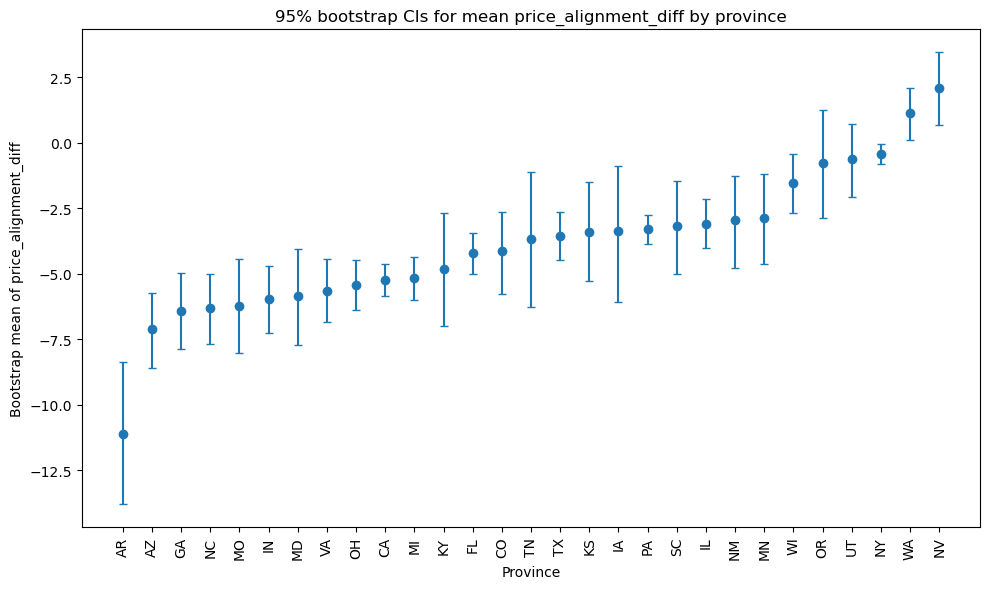

In [59]:
n_boot = 5000
confidence = 95

bootstrap_means_prov = {prov: [] for prov in province_labels}

for i in range(n_boot):
    for prov in province_labels:
        data = df.loc[df["province"] == prov, "price_alignment_diff"] 
        boot_sample = resample(data, replace=True, n_samples=len(data)) # type: ignore
        bootstrap_means_prov[prov].append(np.mean(boot_sample))  # type: ignore

print(f"--- {confidence}% Bootstrap Confidence Intervals for mean(price_alignment_diff) by province ---")
prov_stats = {}
for prov in province_labels:
    means = np.array(bootstrap_means_prov[prov])
    lower = np.percentile(means, (100 - confidence) / 2)
    upper = np.percentile(means, 100 - (100 - confidence) / 2)
    mean_boot = means.mean()
    prov_stats[prov] = (mean_boot, lower, upper)
    print(f"{prov:3s}  mean_boot = {mean_boot:6.2f}   CI {confidence}% = ({lower:6.2f}, {upper:6.2f})")

sorted_provs = sorted(province_labels, key=lambda p: prov_stats[p][0])

means = [prov_stats[p][0] for p in sorted_provs]
lowers = [prov_stats[p][1] for p in sorted_provs]
uppers = [prov_stats[p][2] for p in sorted_provs]

x = np.arange(len(sorted_provs))
yerr = [np.array(means) - np.array(lowers), np.array(uppers) - np.array(means)]

plt.figure(figsize=(10, 6))
plt.errorbar(x, means, yerr=yerr, fmt="o", capsize=3)
plt.xticks(x, sorted_provs, rotation=90)
plt.xlabel("Province")
plt.ylabel("Bootstrap mean of price_alignment_diff")
plt.title(f"{confidence}% bootstrap CIs for mean price_alignment_diff by province")
plt.tight_layout()
plt.show()


The classical one-way ANOVA on price_alignment_diff by province yielded a highly significant p-value, suggesting that the alignment between menu prices and business price ranges is not the same across provinces. However, the assumption checks show that ANOVA is not very reliable here: the Levene test strongly rejects homogeneity of variances (p ≈ $7.0 \cdot 10^{-61}$), the variance ratio is about 4.15, many provinces display clear non-normality, and group sizes are very unbalanced.

The bootstrap confidence intervals for the mean price_alignment_diff provide a more robust picture. In most provinces the 95% CI is entirely below zero, indicating that menu prices tend to be systematically lower than the business-level ranges (e.g., AR around −11 dollars, AZ and GA around −6–7 dollars). A few provinces are close to alignment (NY, WI, OR, UT), and some even show positive differences (WA and especially NV, where the CI lies above zero). These bootstrap results confirm the qualitative conclusion of the ANOVA-that alignment varies substantially by province—while also quantifying which states have the strongest underpricing or overpricing relative to their declared price ranges.


## Is pizza category consumption distributed differently across provinces, or does it remain consistent regardless of the state?

We define

- **$H_0$** (null hypothesis): The distribution of pizza categories is the same across all provinces; pizza category consumption is independent of the province.

- **$H_a$** (alternative hypothesis): The distribution of pizza categories differs across provinces; pizza category consumption depends on the province.

In [60]:
contingency_table = pd.crosstab(df["province"], df["menus.cleanedNames"])

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)

if p < SIGNIFICANCE_LEVEL: # type: ignore
    print("Reject H0: pizza categories distribution depends on the province.")
else:
    print("Fail to reject H0: no evidence that pizza category distribution varies by province.")

Chi-square statistic: 4742.575556432743
Degrees of freedom: 1927
p-value: 2.54381210631018e-237
Reject H0: pizza categories distribution depends on the province.


In [61]:
n = contingency_table.values.sum()
min_dim = min(contingency_table.shape) - 1

cramers_v = np.sqrt(chi2 / (n * min_dim))

print("Cramér's V (Effect Size)")
print(f"Cramér's V: {cramers_v:.4f}")

Cramér's V (Effect Size)
Cramér's V: 0.1088


Pizza category distributions vary significantly across provinces, although the strength of the association is weak (Cramér’s $V = 0.21$).


# Part 2: Statistical modelling and machine learning 

## Statistical models

In [62]:
df = df.rename(columns=lambda c: c.replace(".", "_")).copy()

In [63]:
import statsmodels.formula.api as smf

In [64]:
# Work on a copy for modeling
df_model = df.copy()

# Keep only valid prices
df_model = df_model[
    df_model["menu_price"].notna() & (df_model["menu_price"] > 0)
].copy()

# Log-transform target
df_model["log_price"] = np.log(df_model["menu_price"])

In [79]:
import statsmodels.formula.api as smf

formula = """
log_price ~ 
    C(menus_cleanedNames) + 
    C(province) + C(costal_city) +
    latitude + longitude + 
    priceRangeMin + priceRangeMax +
    menu_is_slice + menu_is_calzone +
    menu_crust_thin + menu_crust_deepdish +
    menu_diet_glutenfree + menu_diet_vegetarian +
    menu_size_small + menu_size_large +
    menu_topping_1 + menu_topping_2 + menu_topping_3plus +
    postalCode + menu_price_mean
"""

model = smf.ols(
    formula,
    data=df_model
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     758.6
Date:                Sat, 03 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:21:47   Log-Likelihood:                 2064.0
No. Observations:                9724   AIC:                            -3914.
Df Residuals:                    9617   BIC:                            -3145.
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------